# Harrison Oates 5508 Assignment 3
CITS5508 - Harrison Oates (22966832)

## Contents
- 1 Diagnosing Cancer
    - 1.1 Data Preprocessing
    - 1.2 Feature Dropping and Scaling
    - 1.3 Logistic Regression and Decision Tree Models
    - 1.4 Results
    - 1.5 Features with Higher Impact
    - 1.6 PCA Scatter Plot
    - 1.7 Biplot of PCA
    - 1.8 Feature Importance Comparison
    - 1.9 95% Variance Features
    - 1.10 PCA Reduced Decision Tree vs Original Dimensionality Decision Tree
- 2 Airline Safety Records
    - 2.1 Data Preprocessing
    - 2.2 Silhouette Score
    - 2.3 K-means Clustering with K = 2
    - 2.4 Scaling and Feature Dropping Explanation
    - 2.5 K-means Cluster Analysis on Differing Variables
    - 2.6 K-means Cluster Analysis of Ratio Variables
- 3 Clustering Analysis on USArrests data
    - 3.1 Hierarchical Clustering
    - 3.2 Hierarchical Clustering Post Scaling
    - 3.3 PCA and Hierarchical Clustering
    - 3.4 K-Means Clustering of PCA


## 1 - Diagnosing Cancer
---
Breast cancer is one of the most common cancers, one of the most effective methods of fighting these kinds of cancers is early intervention. In order to do this, we need to be able to diagnose cancer as early as possible. It can be difficult to diagnose tumours as benign or malignant, depending on this diagnosis the prognosis and treatment of a patient can take wildly different forms. If a tumour is diagnosed as benign when it's actually malignant it can be life threatening. If a tumour is diagnosed as malignant when it's actually benign it can lead to unnecessary treatment and stress for the patient. Machine learning can help identify trends unable to be picked up on by humans and aid in the diagnosis of these tumours.

The goal of this section is to train a model to be able to predict whether a breast tumour is benign or malignant based on a variety of features. We will investigate two models and then we will compare the models performance and discuss the results.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning
import warnings
from tabulate import tabulate
from sklearn.decomposition import PCA


### 1.1 - Data Preprocessing
---
The dataset contains 10 features, including:

- Radius (mean of distances from centre to points on the perimeter)
- Texture (standard deviation of grayscale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness (perimeter^2 / area - 1.0)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry
- Fractal dimension ("coastline approximation" - 1)

The target variable is 'Diagnosis' where (M = malignant, B = benign). In order to analyse the dataset properly the target variable was encoded with a malignant diagnosis represented with a '1' and a benign diagnosis represented with a '0'.

The dataset is first loaded and then the dataset is inspected with some histograms. From this inspection it can be seen that theres a large difference in the scale of the features with some like area_mean ranging between 0 and 2500 and others like compactness_mean ranging between 0 and 0.4. <br>
As one of the models we are investigating is a logistic regression model which is a gradient descent based model we will need to scale our features before training this model which will be done in section <i> 1.2</i>. The correlations between all the features in the dataset are then visualised in a heatmap so that strongly linearly correlated pairs of features can be dropped in section <i>1.2</i>.

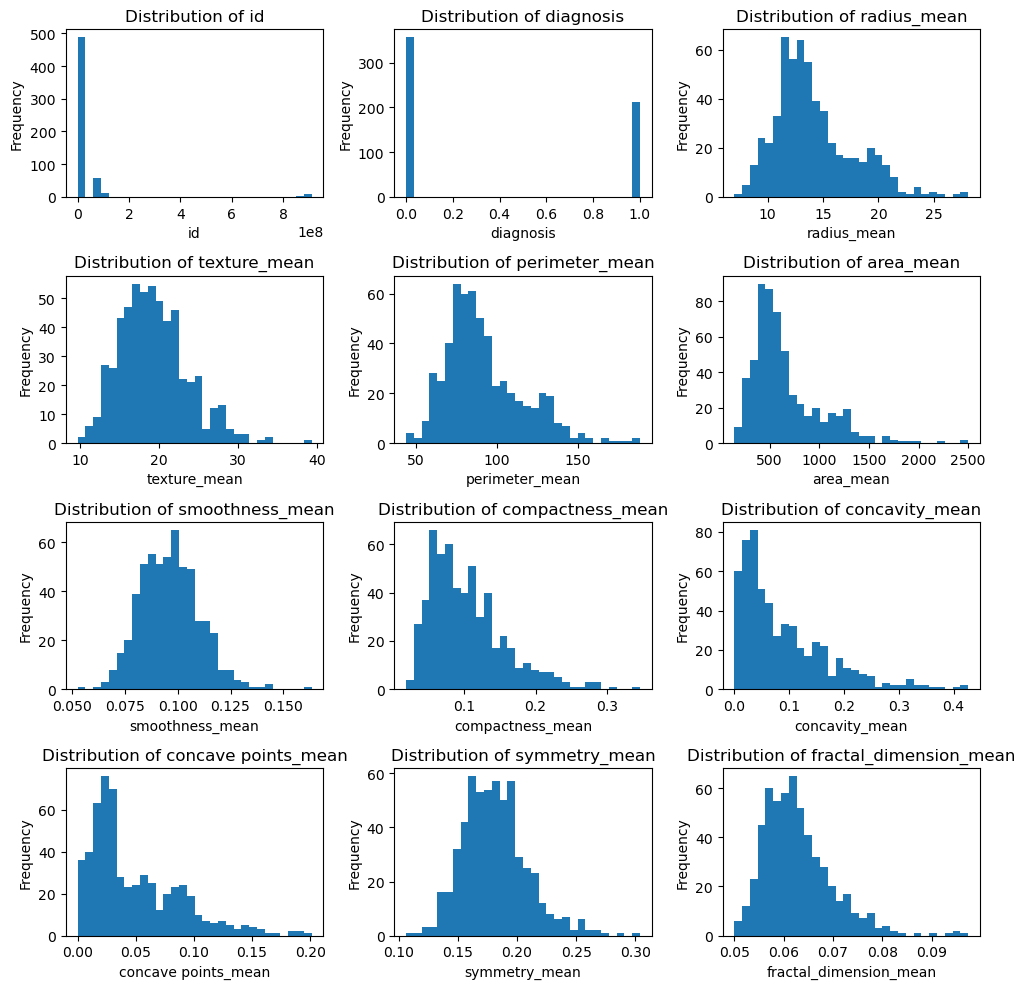

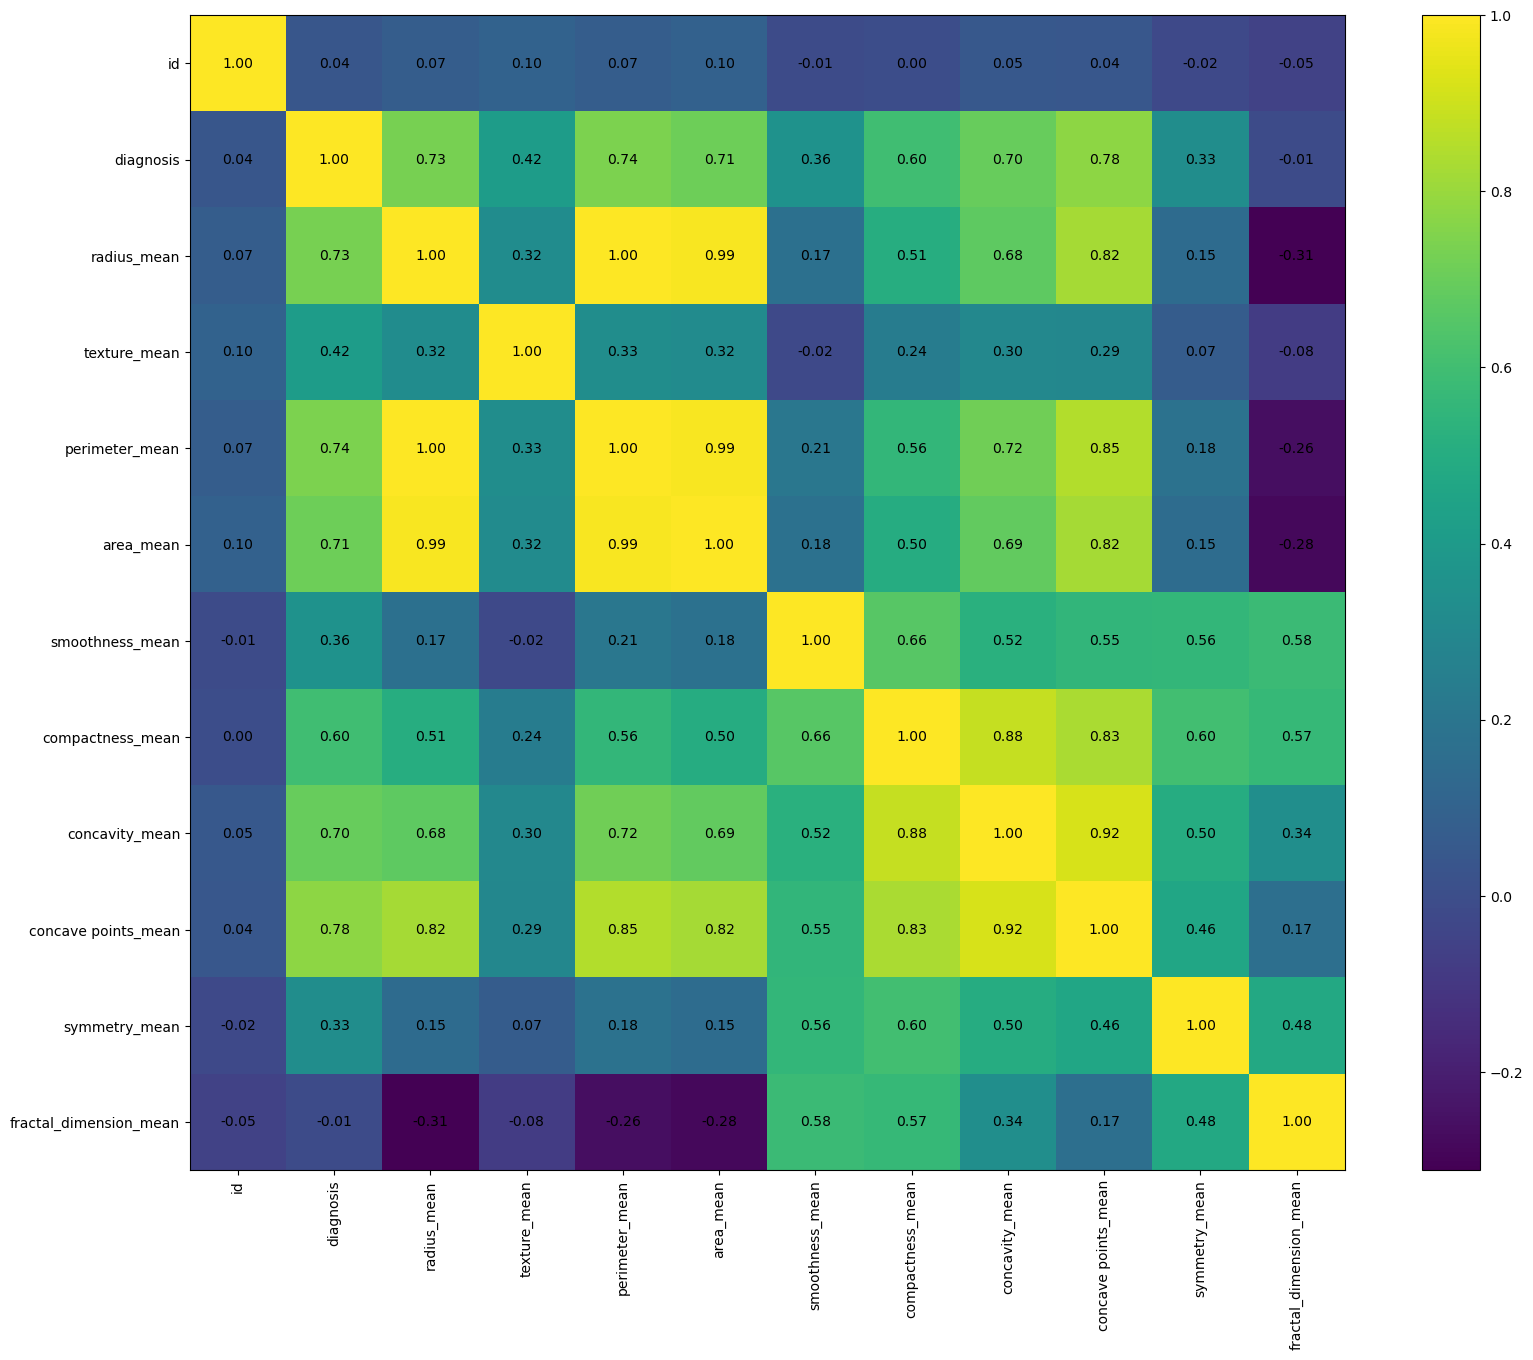

radius_mean and perimeter_mean have correlation 0.9978552814938109
radius_mean and area_mean have correlation 0.9873571700566127
perimeter_mean and area_mean have correlation 0.9865068039913907
concavity_mean and concave points_mean have correlation 0.9213910263788588


In [2]:
# Load in the breast cancer data and replace the diagnosis column with 1 for Malignant and 0 for Benign
data = pd.read_csv('breast-cancer.csv')
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})


# Plot histograms of all features to check distribution
n_cols = 3
n_rows = int(np.ceil(len(data.columns) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i, col_name in enumerate(data.columns):
    r = i // n_cols
    c = i % n_cols
    axs[r, c].hist(data[col_name], bins=30)
    axs[r, c].set_title(f'Distribution of {col_name}')
    axs[r, c].set_xlabel(col_name)
    axs[r, c].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Code from last assignment to generate correlation heatmap to see if any data should be dropped
def generate_heatmap(feature_matrix):
    
    # Calculate the correlation matrix
    corr_matrix = feature_matrix.corr()

    # Create heatmap of all correlations with values in the square of each heatmap cell
    fig, ax = plt.subplots(figsize=(20, 15))
    cax = ax.matshow(corr_matrix, cmap='viridis')

    # Move x-axis labels to bottom
    ax.xaxis.set_ticks_position('bottom')

    # Display the correlation values in each cell
    for (i, j), z in np.ndenumerate(corr_matrix):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

    plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
    fig.colorbar(cax)
    plt.show()

    # Print correlations between all features in the matrix that are greater than 0.9
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                print(f"{corr_matrix.columns[i]} and {corr_matrix.columns[j]} have correlation {corr_matrix.iloc[i, j]}")
    


# Generate heatmap
generate_heatmap(data)


### 1.2 Feature Dropping and Scaling
---
As can be seen in the output of section <i>1.1</i> there are 4 feature pairs with a strong linear correlation (over 0.9) one of the features from each pair are dropped from the dataset. The features dropped are 'perimeter_mean', 'area_mean' and 'concave points_mean'. This is done to reduce the dimensionality of the dataset whilst retaining most of the information in the strongly linear relationship with the other retained feature helping to reduce the risk of overfitting. <br>
The data is then scaled with sklearns standard scaler and then the histograms are regraphed to show the effect of the scaling on our data. As can be seen in the histograms the features now take a standard scale from around -3 to 5 and as a result will all equally contribute to the logistic regression model.

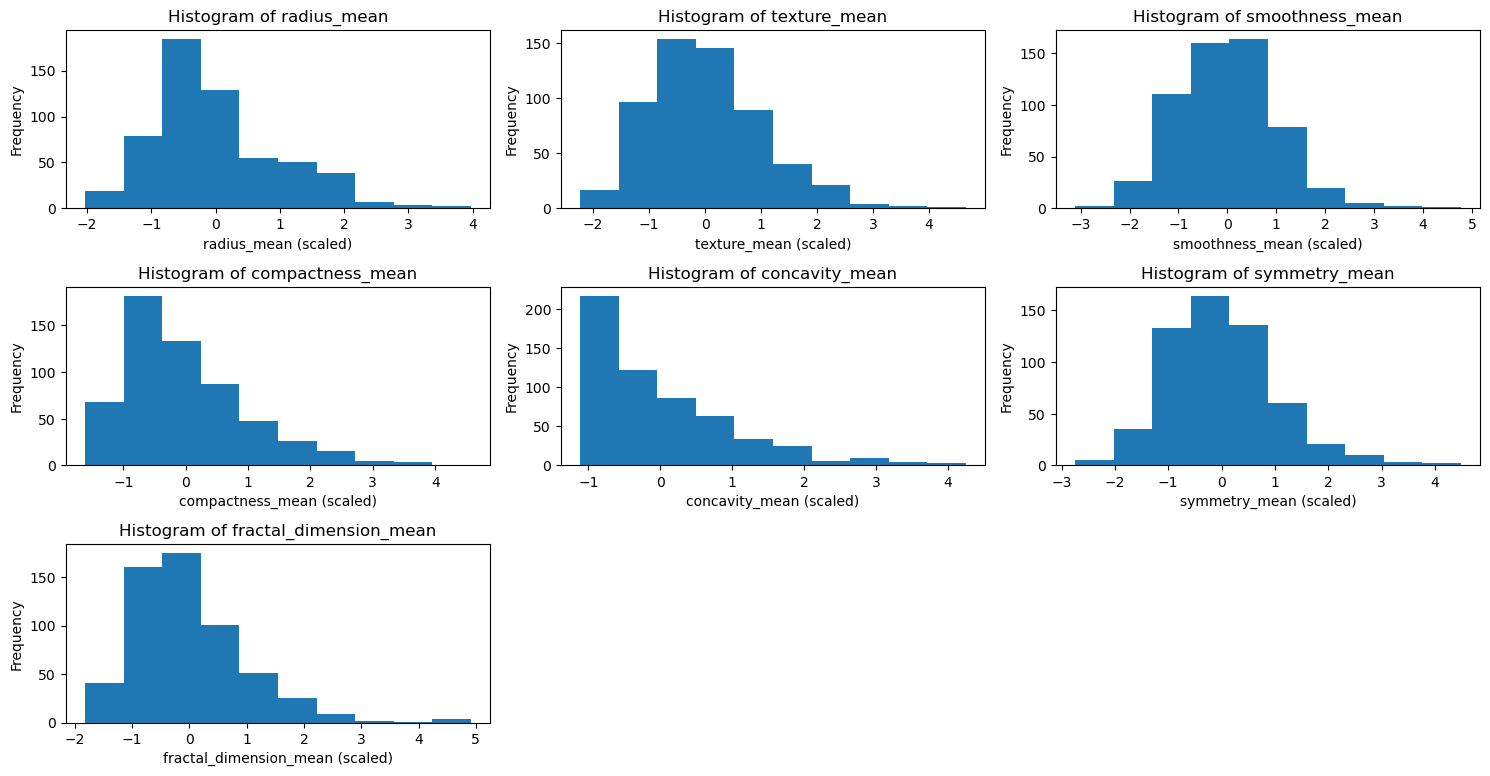

In [3]:
# Drop features with over 0.9 correlation
features_to_drop = ['perimeter_mean', 'area_mean', 'concave points_mean']

# Drop the highly correlated features
data_filtered = data.drop(features_to_drop, axis=1)

# Features and target variable
x = data_filtered.drop(['id', 'diagnosis'], axis=1)
y = data_filtered['diagnosis']

# Scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


# Plot histograms of all scaled features to check distribution
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

# Number of rows/columns
n_rows = 4
n_cols = 3

# Create a figure and subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Iterate over each column (feature) and create a histogram with labels
for i, column in enumerate(x_scaled_df.columns):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].hist(x_scaled_df[column])
    axs[row, col].set_title('Histogram of ' + column)
    axs[row, col].set_xlabel(column + ' (scaled)')
    axs[row, col].set_ylabel('Frequency')

# Remove unused subplots
if len(x_scaled_df.columns) < n_rows * n_cols:
    for i in range(len(x_scaled_df.columns), n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


### 1.3 Logistic Regression and Decision Tree Models
---
After scaling our data we now train a logistic regression model and a decision tree model. We will use 3-fold cross validation to tune the following hyperparameters and then calculate the cross validation score on the testing data for these optimal models.
- Logistic Regression
    - C: Inverse of regularization strength. Smaller values specify stronger regularization.
    - penalty: Used to specify the norm used in the penalization.
    - solver: Algorithm to use in the optimization problem.
    - max_iter: Maximum number of iterations taken for the solvers to converge.

- Decision Tree
    - max_depth: The maximum depth of the tree.
    - min_samples_split: The minimum number of samples required to split an internal node.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.
    - max_features: The number of features to consider when looking for the best split.

The best hyperparameters found for each model through the 3 fold cross validated grid search were:
- Logistic Regression
    - C: 10
    - max_iter: 1000
    - penalty: l2
    - solver: newton-cg
    - tol: 0.0001

- Decision Tree
    - max_depth: None
    - max_features: sqrt
    - min_samples_leaf: 5
    - min_samples_split: 2
    
With these optimal hyperparameters the cross validated score for the logistic regression model was on average ~0.921 compared to the decision tree models average of ~0.877 indicating that both models did very well at classifying samples of the testing data with the logistic regression model slightly (~ 5 percent) better. The accuracy for the logistic regression model and decision tree classifier model is ~0.974 and ~0.912 respectively. The difference in accuracy is likely due to decision tree models tendency to overfit training data, caputring outliers by creating branches specifically for them. This is further highlighted by the relatively minimal limits that ended up being the optimal hyperparameters with no limit on the max_depth. The logistic regression model on the other hand is a much simpler model and as a result is less likely to overfit the training data and capture the outliers. It's also likely that within the context of our data malignant tumours tend to be bigger and more malformed and as a result there is likely some form of linear relationship between the features of size and the outcome of benign or malignant further aiding in the logistic regression models accuracy.


In [4]:
# Ignore warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Split training and testing data with an 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=5508)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)

# Define the hyperparameters grid for Logistic Regression
log_reg_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'penalty': ['l2'],
                'tol': [0.0001, 0.001, 0.01, 0.1],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter': [1000, 2500, 5000]}

# Grid search for Logistic Regression
log_reg_gs = GridSearchCV(LogisticRegression(random_state=5508), log_reg_grid, cv=3)
log_reg_gs.fit(x_train, y_train)

# Find the best hyperparameters
print("Best Parameters for Logistic Regression: ", log_reg_gs.best_params_)

# Define the hyperparameters grid for Decision Tree
dec_tree_grid = {'max_depth': [None, 5, 10, 15, 20],
                 'min_samples_split': [2, 3, 5, 10, 50],
                 'min_samples_leaf': [1, 2, 5, 10, 50],
                 'max_features': [1, 10, 100, 1000, None, 'sqrt', 'log2']}

# Grid search for Decision Tree
dec_tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=5508), dec_tree_grid, cv=3)
dec_tree_gs.fit(x_train, y_train)

best_log_reg = log_reg_gs.best_estimator_
best_dec_tree = dec_tree_gs.best_estimator_

# Find the best hyperparameters
print("Best Parameters for Decision Tree: ", dec_tree_gs.best_params_)

# Perform cross-validation on Logistic Regression model
log_reg_scores = cross_val_score(best_log_reg, x_test, y_test, cv=3)

print("Cross-Validation Scores for Logistic Regression: ", log_reg_scores)
print("Mean Cross-Validation Score for Logistic Regression: ", log_reg_scores.mean())

# Perform cross-validation on Decision Tree model
dec_tree_scores = cross_val_score(best_dec_tree, x_test, y_test, cv=3)

print("Cross-Validation Scores for Decision Tree: ", dec_tree_scores)
print("Mean Cross-Validation Score for Decision Tree: ", dec_tree_scores.mean())

# Predictions using the models with the best hyperparameters
log_reg_gs_pred = best_log_reg.predict(x_test)
dec_tree_gs_pred = best_dec_tree.predict(x_test)

# Print accuracy scores
print("Logistic Regression GS Accuracy:", accuracy_score(y_test, log_reg_gs_pred))
print("Decision Tree GS Accuracy:", accuracy_score(y_test, dec_tree_gs_pred))



Best Parameters for Logistic Regression:  {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}
Best Parameters for Decision Tree:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Cross-Validation Scores for Logistic Regression:  [0.92105263 0.92105263 0.92105263]
Mean Cross-Validation Score for Logistic Regression:  0.9210526315789473
Cross-Validation Scores for Decision Tree:  [0.84210526 0.89473684 0.89473684]
Mean Cross-Validation Score for Decision Tree:  0.8771929824561404
Logistic Regression GS Accuracy: 0.9736842105263158
Decision Tree GS Accuracy: 0.9122807017543859


### 1.4 - Results
---
Here the classification reports are printed in a nice table format where it can be seen that the logistic regression model is better in every way. The logistic regression model has a higher accuracy, precision, recall and f1 score than the decision tree classifier with an F1 score of ~0.979 for benign diagnoses and ~0.964 for malignant diagnoses compared to the decision tree models ~0.932 for benign and ~0.878 for malignant diagnoses. Although the logistic regression model is only slightly better in every category with some improvements as small as 4 percent given the context of the task where the models are predicting whether or not a tumour is benign or malignant these single digit percentage improvements can be very significant. Having a higher recall is the most important metric in this case as this means that the model more successfully predicts malignant tumours, missing positive cases has a much graver outcome than having to have a biopsy to test false positives.

The superior performance of the logistic regression model can be further seen in the confusion matrices displayed below. The logistic regression confusion matrix has 2 false positives (positive being a malignant diagnosis) and 1 false negative where as the decision tree classifier has 5 of each. With these results its clear that the hyperparameter tuned logistic regression model is the better model for this task and would be more appropriate for diagnosing breast cancer especially considering the severe nature of the task where every percentage improvement in precision and recall matters.


╒═════════════════════════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Metrics for Logistic Regression Model   │ Precision          │ Recall             │ F1-Score           │
╞═════════════════════════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ Benign                                  │ 0.9861111111111112 │ 0.9726027397260274 │ 0.9793103448275863 │
├─────────────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Malignant                               │ 0.9523809523809523 │ 0.975609756097561  │ 0.963855421686747  │
├─────────────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│                                         │                    │                    │                    │
╘═════════════════════════════════════════╧════════════════════╧════════════════════╧════════════════════╛
╒═══════════════════════════════════╤

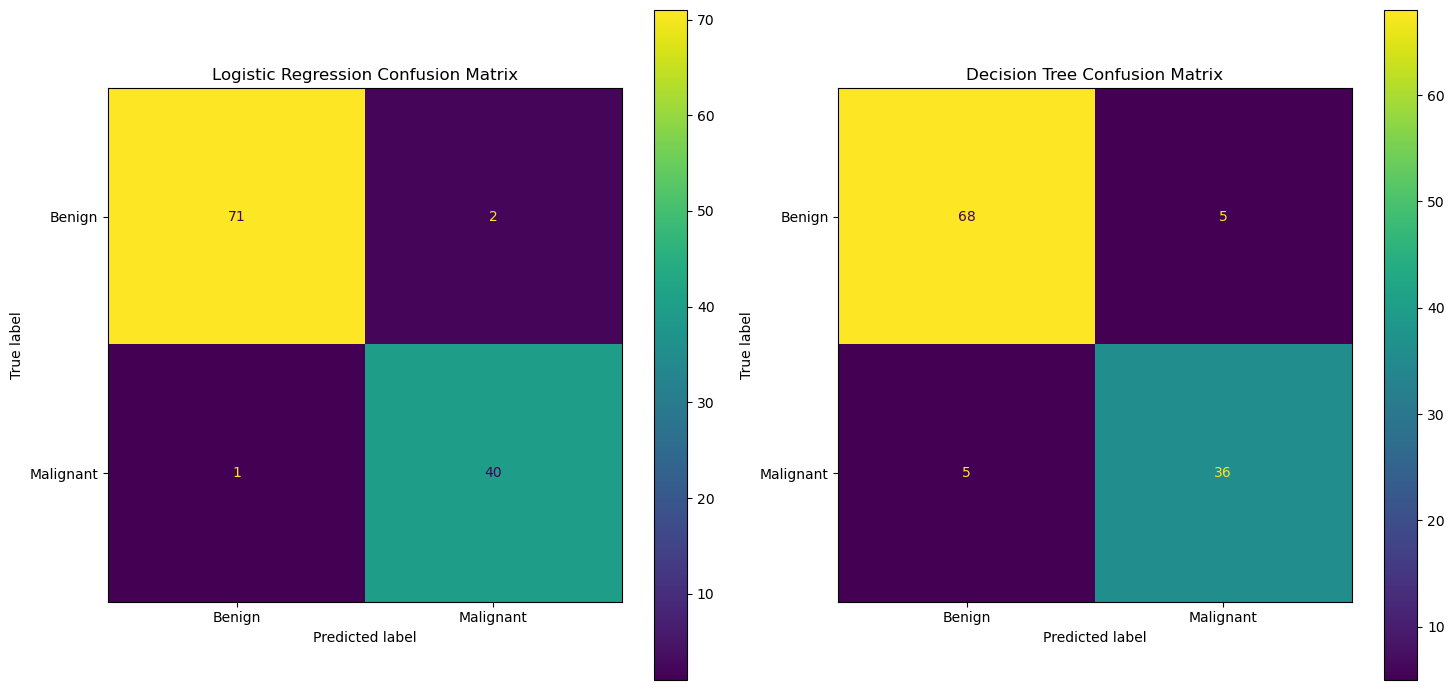

In [5]:
# Classification Reports
log_reg_report = classification_report(y_test, log_reg_gs_pred, output_dict=True)
dec_tree_report = classification_report(y_test, dec_tree_gs_pred, output_dict=True)

# Create classification report table
classification_report_table_log_reg = [["Metrics for Logistic Regression Model", "Precision", "Recall", "F1-Score"],
                               ["Benign", log_reg_report["0"]["precision"], log_reg_report["0"]["recall"],
                                log_reg_report["0"]["f1-score"]],
                               ["Malignant", log_reg_report["1"]["precision"], log_reg_report["1"]["recall"],
                                log_reg_report["1"]["f1-score"]],
                               ["", "", "", "", ""]]

# Print classification report table
print(tabulate(classification_report_table_log_reg, headers="firstrow", tablefmt="fancy_grid"))

# Create classification report table
classification_report_table_dec_tree = [["Metrics for Decision Tree Model", "Precision", "Recall", "F1-Score"],
                               ["Benign", dec_tree_report["0"]["precision"], dec_tree_report["0"]["recall"],
                                dec_tree_report["0"]["f1-score"]],
                               ["Malignant", dec_tree_report["1"]["precision"], dec_tree_report["1"]["recall"],
                                dec_tree_report["1"]["f1-score"]],
                               ["", "", "", "", ""]]

# Print classification report table
print(tabulate(classification_report_table_dec_tree, headers="firstrow", tablefmt="fancy_grid"))

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Confusion matrix for Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_gs_pred, display_labels=["Benign", "Malignant"], ax=ax[0])
ax[0].set_title("Logistic Regression Confusion Matrix")

# Confusion matrix for Decision Tree
ConfusionMatrixDisplay.from_predictions(y_test, dec_tree_gs_pred, display_labels=["Benign", "Malignant"], ax=ax[1])
ax[1].set_title("Decision Tree Confusion Matrix")

# Ensure subplots do not overlap
plt.tight_layout()
plt.show()



### 1.5 - Features with Higher Impact
---
Here the feature importances for both models are extracted and then visualised in a bar chart. As can be seen in this bar chart there are some key differences between both models and features. In the logistic regression model 'mean_radius' is the most impactful feature for predicting the tumour status with ~3.5 importance. This is followed by 'mean_concavity', 'mean_smoothness' and 'mean_texture' with ~1.8, ~1.6 and ~1.5 importance respectively. This to be expected as tumours that are large or malformed tend to be malignant more often then not and as a result theres possibly a strong linear relationship between the tumour nuclei size and malignancy.

The decision tree classifier has a similarly most important feature of 'mean_radius' and second most important feature of 'mean_concavity', however despite theses similarities the decision tree classifier has a very low feature importance for almost all the features. Each model emphasises different features with the logistic model taking a much higher importance in all the features and placing an importance on 'mean symmetry' and 'mean fractal dimension' where as the decision tree places virtually 0 importance on these features. This discrepancy in the feature importances is likely due to the different natures of the models with the logistic regression model having a linear approach and the decision tree model capturing a more complex non-linear relationship.

It is to be expected that 'mean radius', 'mean concavity' and similarly important features of tumour general size are important as irregular or rapid growth of tumours can be a strong indicator of malignancy.


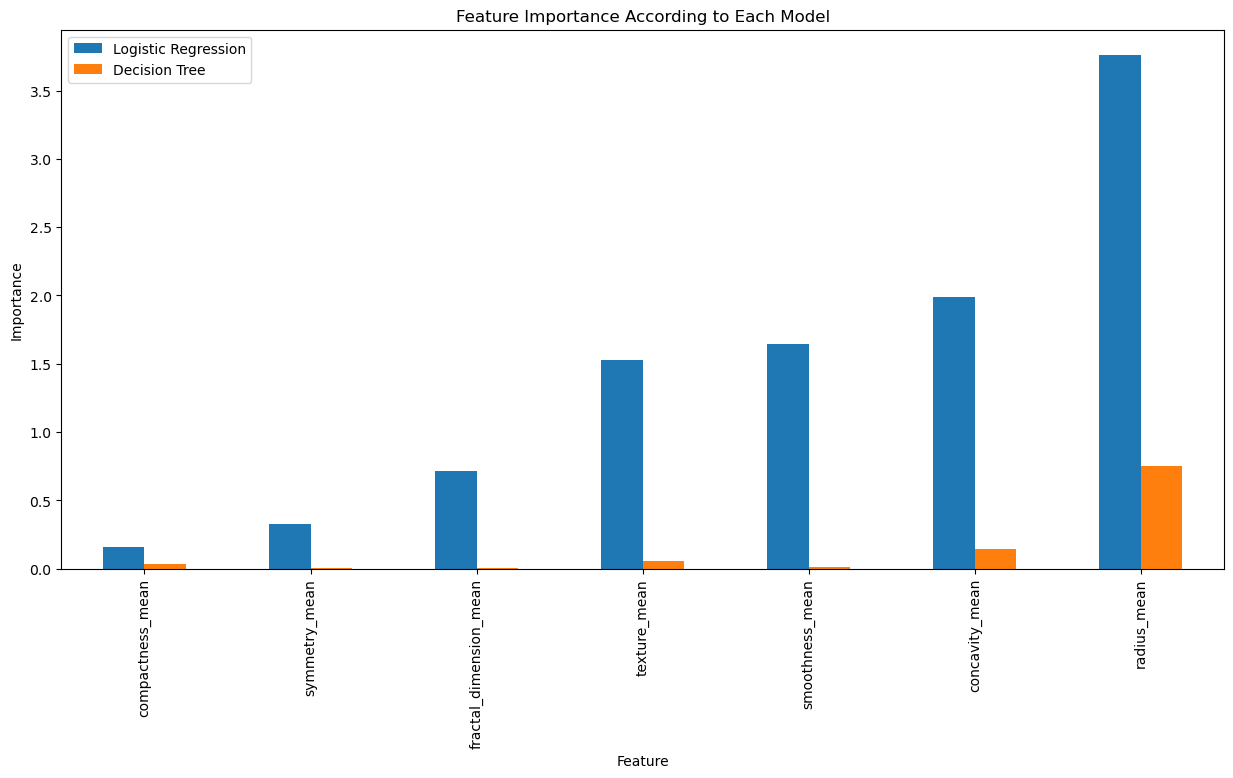

In [6]:
# Get the feature importance for both models
log_reg_feature_importance = abs(best_log_reg.coef_[0])
dec_tree_feature_importance = best_dec_tree.feature_importances_

# Create a dataframe for visualization
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Logistic Regression': log_reg_feature_importance,
    'Decision Tree': dec_tree_feature_importance
})

# Make the feature column the index for easy plotting
feature_importance_df.set_index('Feature', inplace=True)

# Sort by logistic regression importance
feature_importance_df.sort_values(by='Logistic Regression', inplace=True)

# Visualize feature importance
feature_importance_df.plot(kind='bar', figsize=(15, 7))
plt.title('Feature Importance According to Each Model')
plt.ylabel('Importance')
plt.show()

### 1.6 PCA Scatter Plot
---
Using PCA a scatter plot of the data on the first two principal components is generated. These two principal components are responsible for ~ 0.74 of the total variance in the data. The scatter plot is coloured orange for benign diagnoses and purple for malignant diagnoses and as can be seen there is a clear separation between the two classes. The benign tumours are more clustered together in a smaller region of the plot which suggests that benign tumours have similar features leading to less variability and a tighter distribution of them. On the other hand the malignant tumours are distributed further apart which suggests that malignant tumours have a much larger degree of variability in their features.

This difference between the variability of the features for each tumour makes sense as malignant tumours are generally more malformed and irregular in shape and size than benign tumours leading to a bigger variability in the features recorded for them. Whilst PCA providies a good view of the data there is still an approximately 26% of the variance in the data that is not captured.


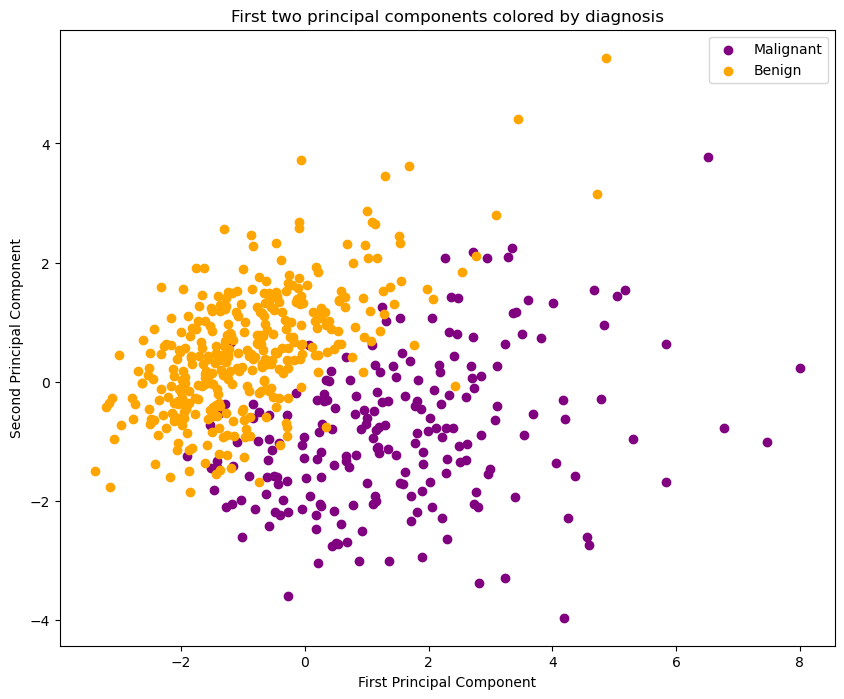

Proportion of Variance Explained by First Two Principal Components: 0.740675393398608


In [7]:
# Create the PCA instance and fit and transform the data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)

# Create a new dataframe with the two components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the target variable "diagnosis"
final_pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

# Generate the scatter plot
plt.figure(figsize=(10,8))

# Split the data by diagnosis and plot each separately
for diagnosis, color in zip((1, 0), ('purple', 'orange')):
    indices = final_pca_df['diagnosis'] == diagnosis
    plt.scatter(final_pca_df.loc[indices, 'PC1'], 
                final_pca_df.loc[indices, 'PC2'], 
                color=color)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First two principal components colored by diagnosis')
plt.legend(['Malignant', 'Benign'])

plt.show()

# Calculate and print the proportion of data variance that the first two principal components retain
print('Proportion of Variance Explained by First Two Principal Components:', sum(pca.explained_variance_ratio_))


### 1.7 Biplot of PCA
---
In this biplot the first two principal components are plotted with vectors corresponding to features in the dataset. The direction of each feature indicates how each feature contributes to the two principal components. Looking at this biplot it can be seen that features like 'mean_concavity' and 'mean_compactness' have significant relationships with the first principal component which contributes the most to the distinction between the two classes. On the other hand features such as 'mean_radius' and 'mean_fractal_dimension' have a strong association with the second principal component. Additionally there are acute angles between the features of 'mean_smoothness' and 'mean_symmetry' aswell as 'mean_texture' and 'mean_radius" this suggests a strong relationship between these features which makes sense as they are similar metrics. 

The results of these vectors suggest that the most important features for both principal components are 'mean_radius', 'mean_fractal_dimension', 'mean_concavity' and 'mean_compactness'.

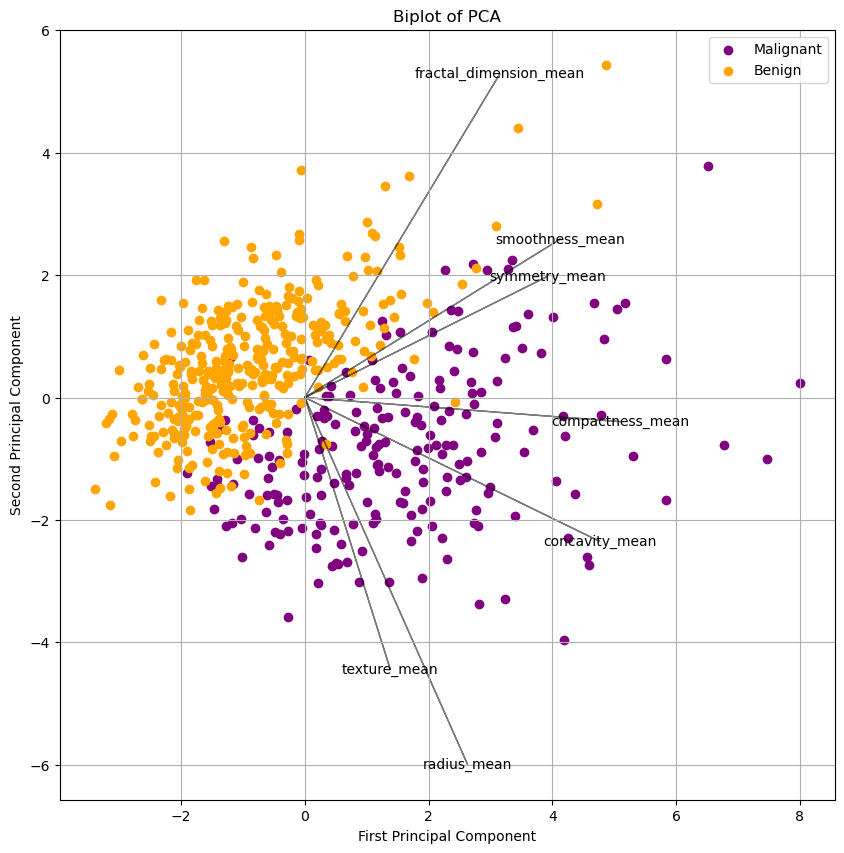

In [8]:
# Adjust the size of the figure
plt.figure(figsize=(10, 10))

# Scatter plot of the data
for diagnosis, color in zip((1, 0), ('purple', 'orange')):
    indices = final_pca_df['diagnosis'] == diagnosis
    plt.scatter(final_pca_df.loc[indices, 'PC1'], 
                final_pca_df.loc[indices, 'PC2'], 
                c=color)

# Add variable arrows
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0, pca.components_[0, i]*10, pca.components_[1, i]*10, color='black', alpha=0.5)
    plt.text(pca.components_[0, i]*10, pca.components_[1, i]*10, x.columns[i], color='black', ha='center', va='center')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Biplot of PCA')
plt.legend(['Malignant', 'Benign'])
plt.grid()

# Show the plot
plt.show()

### 1.8 Feature Importance Comparison
---
The results of the biplots feature importance is similar to the results from task 2 with common important features such as 'mean_radius' and 'mean_concavity' however there are some key differences such  as the biplot suggesting that 'fractal_dimension_mean' is important to the second principal component where as in task 2 this feature was relatively low in importance for both models. This difference can be attributed to the difference between task 2s importances being drawn from the models that are trained on all the features where as the biplot shows features importances to the reduced dimensionality first and second principal components. It's possible that some features that were important to the model that was trained on all the features are not as important to the variability of the data and as a result don't affect the first and second principal components much. Similarly it's possible that a feature that is large in importance for the variability of the data to have a high importance in the biplot but not have as great of an affect on the outcome of the diagnosis and thus having a lower importance in the task 2 feature importances which is likely the case with 'mean_fractal_dimension'.

### 1.9 95% Variance Features
---
Here PCA is performed on the dataset to find the minimum number of components required for 95% of the explained variance which is 5 components meaning the new dimension of the data after this reduction is 5. A decision tree model is then trained using these components as features. This model is then put through a 3-fold cross validated grid search to find the optimal hyperparameters for this new model. This optimal hyperparameter model is then tested on the test data and the results are printed and then discussed in section <i> 1.10 </i>. The accuracy for this PCA reduced dimensionality decision tree classifier is 0.912 which is the same as the result from task 1 in section <i>1.3</i> however the cross validation score is on average ~0.823 which is lower than the task 1 average of 877 suggesting that there is some reduction in performance from this reduced dimensionality model.

In [9]:
# Apply PCA to the data and check the number of components chosen
pca_95 = PCA(n_components=0.95)
x_pca_95 = pca_95.fit_transform(x_scaled)
print("Number of components chosen: ", pca_95.n_components_)

# Split the new features into training and testing sets
x_train_pca, x_test_pca, y_train_95, y_test_95 = train_test_split(x_pca_95, y, test_size=0.2, random_state=5508)

# Define the hyperparameters grid for Decision Tree
dec_tree_grid = {'max_depth': [None, 5, 10, 15, 20],
                 'min_samples_split': [2, 3, 5, 10, 50],
                 'min_samples_leaf': [1, 2, 5, 10, 50],
                 'max_features': [1, 10, 100, 1000, None, 'sqrt', 'log2']}

# Grid search for Decision Tree
dec_tree_gs_95 = GridSearchCV(DecisionTreeClassifier(random_state=5508), dec_tree_grid, cv=3)
dec_tree_gs_95.fit(x_train_pca, y_train_95)

best_dec_tree_95 = dec_tree_gs_95.best_estimator_

# Find the best hyperparameters
print("Best Parameters for Decision Tree: ", dec_tree_gs_95.best_params_)

# Predictions using the models with the best hyperparameters
dec_tree_gs_pred_95 = best_dec_tree_95.predict(x_test_pca)

# Perform cross-validation on PCA Decision Tree model
dec_tree_scores = cross_val_score(best_dec_tree, x_test_pca, y_test_95, cv=3)

print("Cross-Validation Scores for Decision Tree: ", dec_tree_scores)
print("Mean Cross-Validation Score for Decision Tree: ", dec_tree_scores.mean())

# Print accuracy of model with best hyperparameters
print("Decision Tree GS Accuracy:", accuracy_score(y_test_95, dec_tree_gs_pred_95))



Number of components chosen:  5
Best Parameters for Decision Tree:  {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Cross-Validation Scores for Decision Tree:  [0.81578947 0.89473684 0.76315789]
Mean Cross-Validation Score for Decision Tree:  0.8245614035087719
Decision Tree GS Accuracy: 0.9122807017543859


### 1.10 PCA Reduced Decision Tree vs Original Dimensionality Decision Tree
---
Here the metrics are put in a nice table and graphed so the results can be easily seen and compared. It can be seen from the classification report tables that the reduced dimensionality model performs very well. The precision for the original model is ~0.932 and ~0.878 for benign and malignant tumours compared to the reduced dimensionality models ~0.944 and ~0.860 meaning that both models are adept at classifying benign and malignant cases with the lower dimensionality model slightly better at classifying benign tumours and the original model slightly better at classifying malignant tumours. 

Despite the reduction in dimensions the model in fact has a higher precision for benign and a slightly lower precision for malignant tumours which indicates that the reduced dimensionality model has slightly more false positives but less flase negatives. The recall results are similar with a slightly lower recall for benign tumours (~0.918 vs ~0.932) and a slightly higher recall for malignant tumours (~0.902 vs ~0.878) indicating that the reduced dimensionality model is less likely to miss malignant cases which is a very important attribute even if its minor. The overall F1-scores are very similar with a slightly better benign f1 score for the original model of ~0.932 vs ~0.931 and a slightly better malignant f1 score for the reduced dimensionality model of ~0.881 vs ~0.878.

These subtle differences in the metrics between the two models can be seen further in the confusion matrices of each. In the original decision tree confusion matrix it can be seen that the model has 5 false positives (malignant predictions that were benign) and 5 false negatives (benign predictions that were malignant) on the other hand the reduced dimensionality model had 6 false positives and 4 false negatives. This is consistent with the results discussed above where the reduced dimensionality model had a slightly higher malignant recall.

All in all both models perform very well and there are minor differences in the metrics of both models, given the context of predicting breast cancer tumour status the reduced dimensionality model is the one I would recommend in practice as it has a slightly better malignant recall which is more important as it is better to have a false positive than a false negative in the context of malignancy prediction. Additionally having a lower dimensionality is beneficial as it can reduce the computational cost of the model. 

╒════════════════════════════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Metrics for Original Decision Tree Model   │ Precision          │ Recall             │ F1-Score           │
╞════════════════════════════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ Benign                                     │ 0.9315068493150684 │ 0.9315068493150684 │ 0.9315068493150684 │
├────────────────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Malignant                                  │ 0.8780487804878049 │ 0.8780487804878049 │ 0.8780487804878049 │
├────────────────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│                                            │                    │                    │                    │
╘════════════════════════════════════════════╧════════════════════╧════════════════════╧════════════════════╛
╒═════════

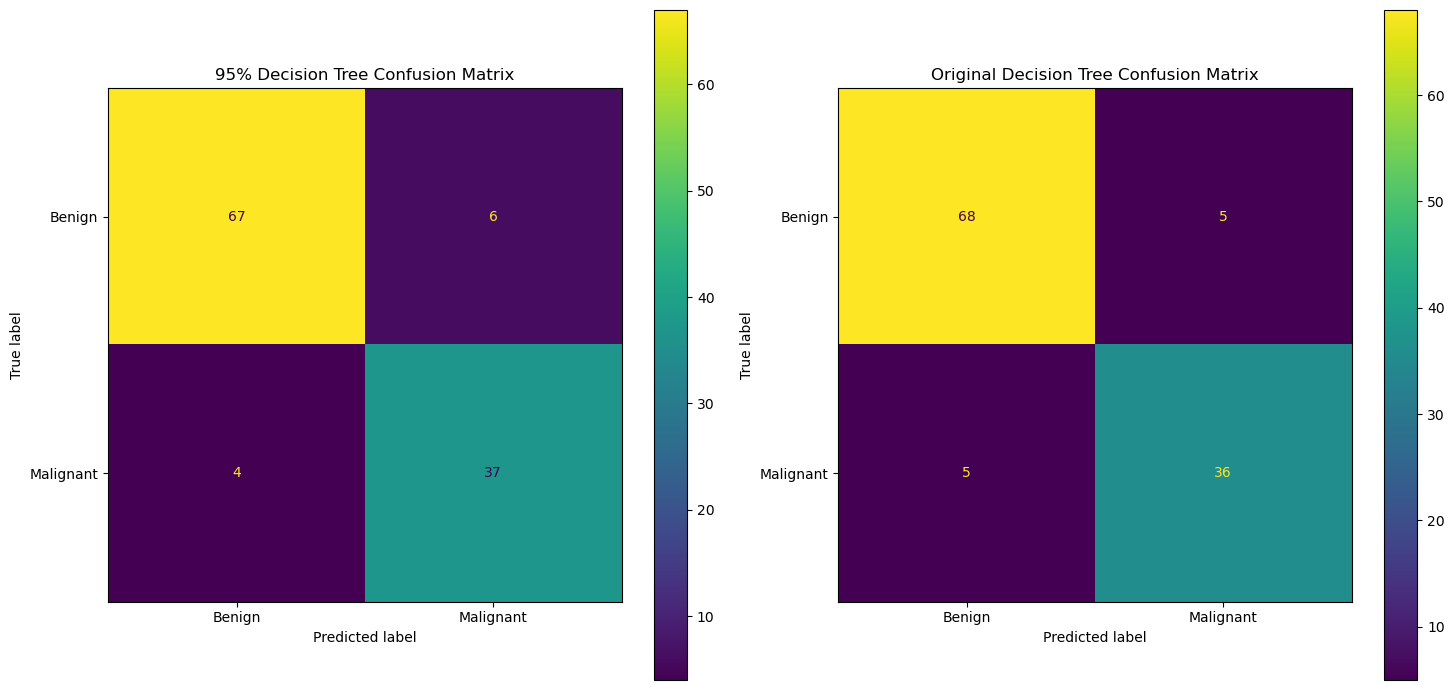

In [10]:
# Classification Reports
dec_tree_report_95 = classification_report(y_test_95, dec_tree_gs_pred_95, output_dict=True)
dec_tree_report = classification_report(y_test, dec_tree_gs_pred, output_dict=True)

# Create and print classification report tables for the original and 95 percent PCAd models
classification_report_table_log_reg = [["Metrics for Original Decision Tree Model", "Precision", "Recall", "F1-Score"],
                               ["Benign", dec_tree_report["0"]["precision"], dec_tree_report["0"]["recall"],
                                dec_tree_report["0"]["f1-score"]],
                               ["Malignant", dec_tree_report["1"]["precision"], dec_tree_report["1"]["recall"],
                                dec_tree_report["1"]["f1-score"]],
                               ["", "", "", "", ""]]

print(tabulate(classification_report_table_log_reg, headers="firstrow", tablefmt="fancy_grid"))


classification_report_table_dec_tree = [["Metrics for 95% Decision Tree Model", "Precision", "Recall", "F1-Score"],
                               ["Benign", dec_tree_report_95["0"]["precision"], dec_tree_report_95["0"]["recall"],
                                dec_tree_report_95["0"]["f1-score"]],
                               ["Malignant", dec_tree_report_95["1"]["precision"], dec_tree_report_95["1"]["recall"],
                                dec_tree_report_95["1"]["f1-score"]],
                               ["", "", "", "", ""]]


print(tabulate(classification_report_table_dec_tree, headers="firstrow", tablefmt="fancy_grid"))


# Plot the confusion matrices for the original and 95 percent PCAd models
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ConfusionMatrixDisplay.from_predictions(y_test_95, dec_tree_gs_pred_95, display_labels=["Benign", "Malignant"], ax=ax[0])
ax[0].set_title("95% Decision Tree Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, dec_tree_gs_pred, display_labels=["Benign", "Malignant"], ax=ax[1])
ax[1].set_title("Original Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()


## 2 Airline Safety Records
---
In this section we explore which airlines are similar to eachother based on modelling their past safety records are incidents and fatalities that happen to airlines simply a random occurance thats bound to happen over the millions of flights per year or are there truly airlines that are more dangerous than others. In order to investigate which airlines are similar a clustering analysis method will be applied to the data with a K-means clustering model. This models performance will be investigated and the results will be discussed.

The data that is being used is from a csv file called airline-safety that contains varying features that describe metrics for airlines such as avaliable seats per km or incidents over multiple time periods.

In [11]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

### 2.1 Data Preprocessing
---
There are 8 features to our airline safety data which are as follows
- airline (asterisk indicates that regional subsidiaries are included)
- avail seat km per week: available seat kilometres flown every week
- incidents 85 99: total number of incidents, 1985-1999
- fatal accidents 85 99: total number of fatal accidents, 1985-1999
- fatalities 85 99: total number of fatalities, 1985-1999
- incidents 00 14: total number of incidents, 2000-2014
- fatal accidents 00 14: total number of fatal accidents, 2000-2014
- fatalities 00 14: total number of fatalities, 2000-2014

The data is loaded into a dataframe and then the airline columns are dropped as they are not numeric and unimportant in the goal of clustering similar numerical data points. Some histograms of the remaining numerical features are then graphed to show the distribution of the features. From these histograms it's apparent that scaling will be necessarys as the features take on different ranges and K-means clustering being a distance model will be affected by the differently distributed features. 

Then the correlations between all the features are calculated and displayed in a heatmap to see if any feature pairs have a strongly linear relationship. From inspecting this heatmap it can be seen that despite some feature pairs having a relatively strong correlation of over 0.8 none have an over 0.9 correlation and as a result no feature pairs will be dropped. Finally the data is scaled with sclearns standard scaler to ensure all the features contribute equally in the K-means clustering.


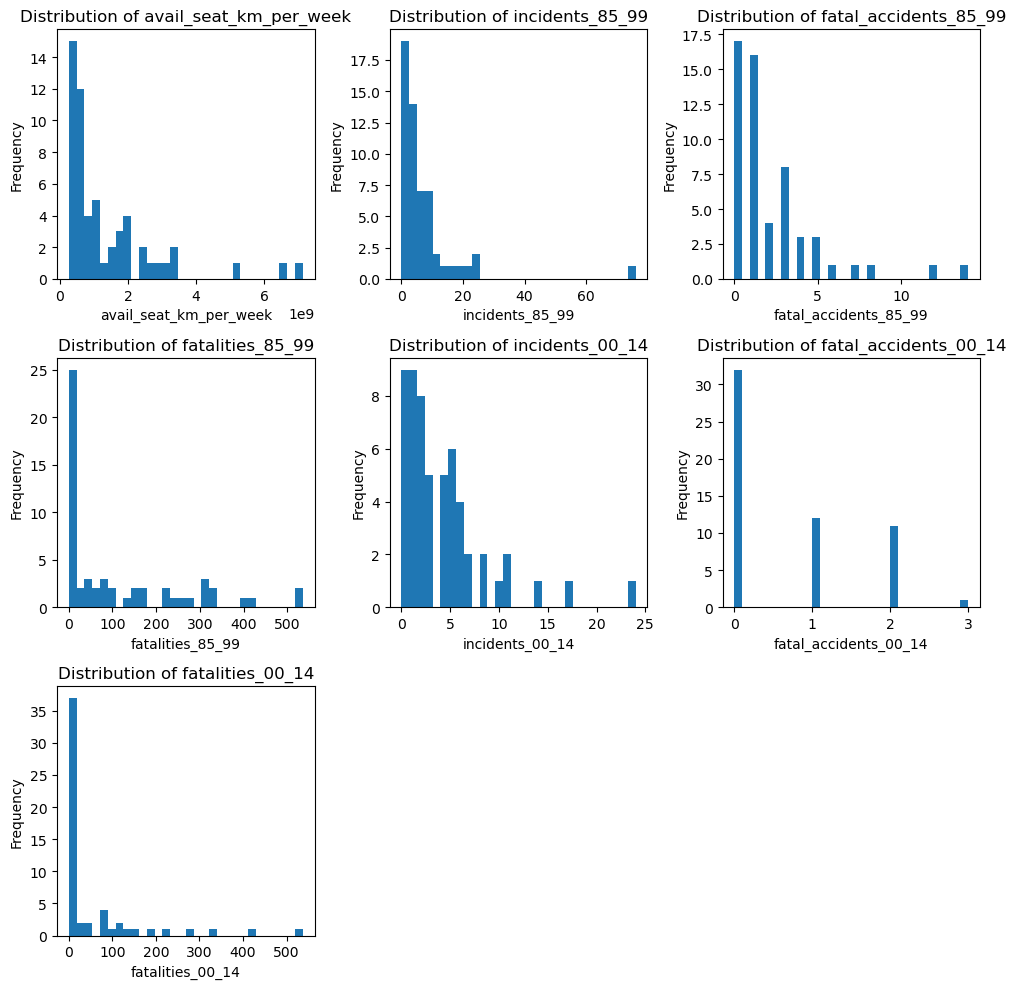

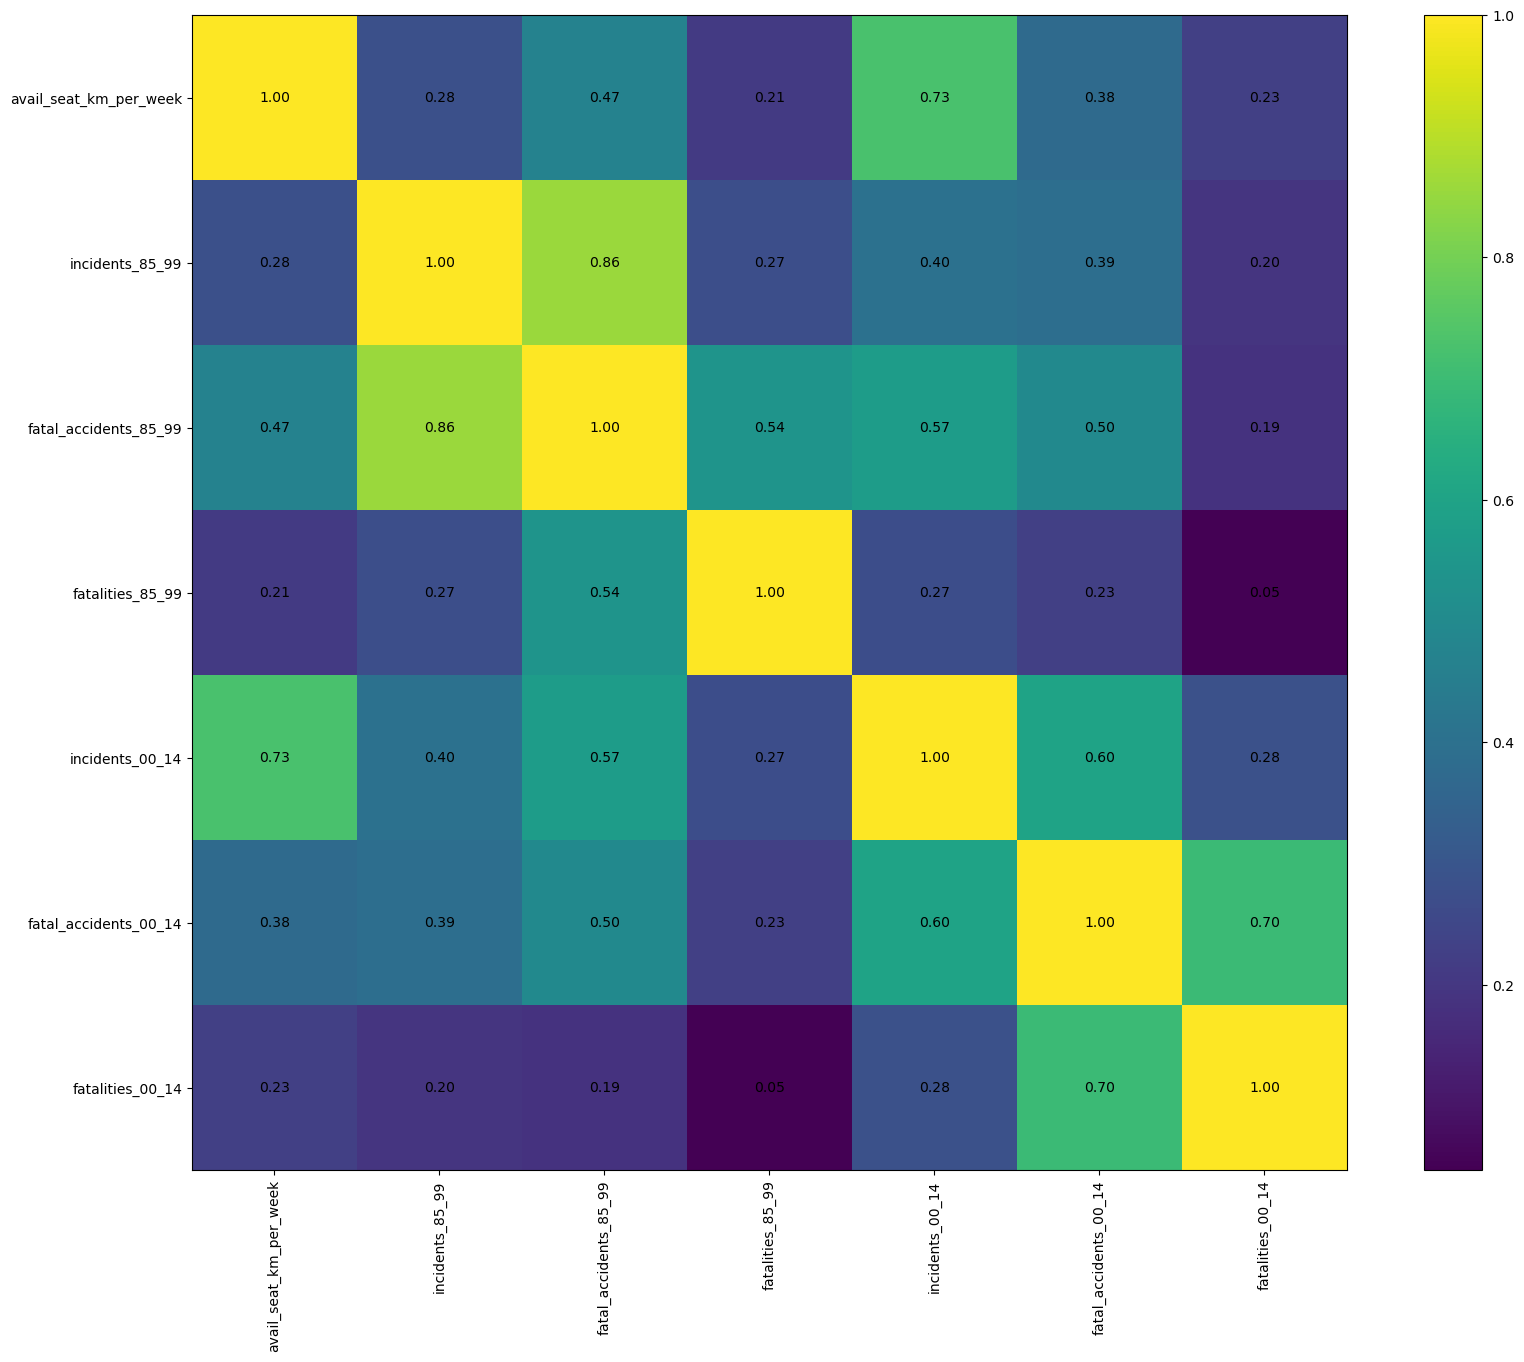

In [12]:
# Load in the data
airline_data = pd.read_csv("airline-safety.csv")

# drop airline columns
df_numeric = airline_data.select_dtypes(include=['float64', 'int64'])
# Plot histograms of all features to check distribution
n_cols = 3
n_rows = int(np.ceil(len(df_numeric.columns) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i, col_name in enumerate(df_numeric.columns):
    r = i // n_cols
    c = i % n_cols
    axs[r, c].hist(df_numeric[col_name], bins=30)
    axs[r, c].set_title(f'Distribution of {col_name}')
    axs[r, c].set_xlabel(col_name)
    axs[r, c].set_ylabel('Frequency')

# Remove unused subplots
if len(df_numeric.columns) < n_rows * n_cols:
    for i in range(len(df_numeric.columns), n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

def generate_heatmap(feature_matrix):
    
    # Calculate the correlation matrix
    corr_matrix = feature_matrix.corr()

    # Create heatmap of all correlations with values in the square of each heatmap cell
    fig, ax = plt.subplots(figsize=(20, 15))
    cax = ax.matshow(corr_matrix, cmap='viridis')

    # Move x-axis labels to bottom
    ax.xaxis.set_ticks_position('bottom')

    # Display the correlation values in each cell
    for (i, j), z in np.ndenumerate(corr_matrix):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

    plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
    fig.colorbar(cax)
    plt.show()

    # Print correlations between all features in the matrix that are greater than 0.9
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                print(f"{corr_matrix.columns[i]} and {corr_matrix.columns[j]} have correlation {corr_matrix.iloc[i, j]}")
    


# Generate heatmap
generate_heatmap(df_numeric)

# Scale the features
scaler = StandardScaler()
airline_scaled = scaler.fit_transform(df_numeric)



### 2.2 - Silhouette Score
---
Here the silhouette scores for different numbers of clusters between 2 and 8 are calculated and plotted, these silhouette scores measure how close each point in one cluster is to the points in the neighbouring cluster with higher values indicating that the point is close to its own cluster and far away from neighbouring clusters. A K-means clustering model is initialised for each K then fitted to the scaled airline data and then its silhouette score is calculated. It's clear to see from this plot of the different silhouette scores that a K value or number of clusters of 2 is the most optimal with a silhouette score of ~0.45 which is higher than any other value of K. This would be the best choice however a choice of K = 3 could also be valid as its only a slightly lower silhouette score of ~ 0.39.

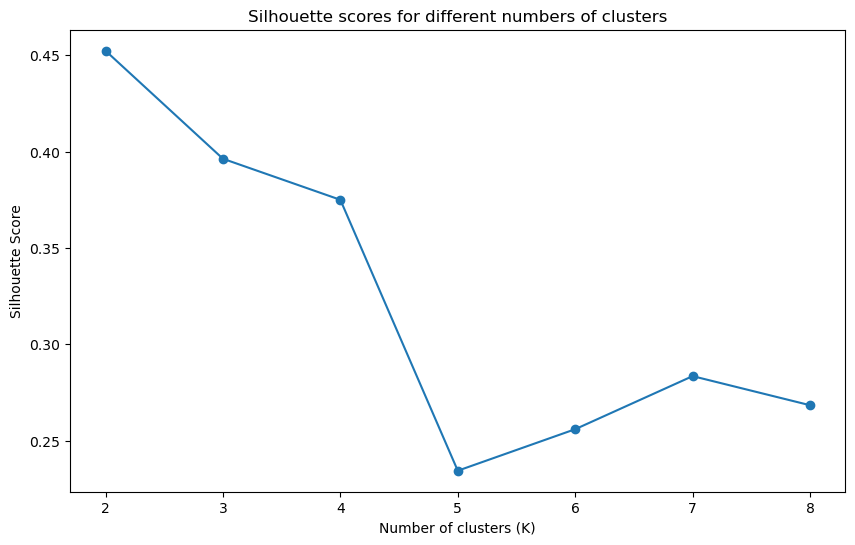

In [13]:
# Ignore warnings to stop OMP_NUM_THREADS warning from printing
warnings.filterwarnings('ignore')

# Prepare an empty list to store the silhouette scores
silhouette_scores = []

# Iterate over the desired range of K values
for k in range(2, 9):
    # Initialize the KMeans model with the current K value
    kmeans = KMeans(n_init='auto', n_clusters=k, random_state=5508)
    
    # Fit the model to the scaled data
    kmeans.fit(airline_scaled)
    
    # Predict the cluster labels for the scaled data
    labels = kmeans.predict(airline_scaled)
    
    # Compute the silhouette score for the current K value and append to the list
    silhouette_scores.append(silhouette_score(airline_scaled, labels))
    

plt.figure(figsize=(10, 6))
plt.plot(range(2, 9), silhouette_scores, marker='o')
plt.title('Silhouette scores for different numbers of clusters')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

### 2.3 - K-means Clustering with K = 2
---
Here the K-means clustering is performed with the optimal K value found in the above section. The cluster labels are then added back to the original dataframe and then the mean of each feature for each cluster is displayed. Cluster 0 represents the more dangerous airlines with a higher average incidents, fatal accidents and fatalities across both the 85_99 timespan and the 00_14 timespan with an average of 19.5 incidents, ~6 fatal accidents resulting in ~200 fatalities in 85-99 and then ~9.4 incidents with ~1.9 fatal accidents resulting in ~183 fatalities in 00-14. It's likely that this cluster contains some of the larger more established airlines as the average avaliable seat kilometers per week is ~2.6 times bigger than cluster 1. With this larger operation and flight times it's likely that the increase in incidents and accidents come from more flight time. Across the board the values decrease from 85_99 suggesting that airlines got safer as time went on. 

In cluster 1 theres an average ~3.8 incidents with ~1.16 fatal accidents resulting in ~88.8 fatalities in 85-99 and then in 00-14 theres ~2.7 incidents with ~0.32 fatal accidents resulting in ~20.8 fatalities. It's likely that this cluster contains smaller airlines with a much smaller average avaliable seat kilometers per week compared to cluster 0. This reduction in flying time is likely the reason theres way less incidents and accidents. Overall however the values of incidents, accidents and fatalities are much lower in 00-14 than in 85-99 suggesting that both airlines in cluster 0 and 1 got safer over time.

In [14]:
# Perform K-means clustering with K value from above
kmeans = KMeans(n_clusters=2, random_state=5508)
labels = kmeans.fit_predict(airline_scaled)

# Add the cluster labels to the original DataFrame
airline_data['Cluster'] = labels

# Display the mean of each feature for each cluster
cluster_characteristics = airline_data.groupby('Cluster')[df_numeric.columns].mean()
cluster_characteristics

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
Cluster,,,,,,,
0,2.641290e+09,19.500000,5.916667,199.166667,9.416667,1.916667,183.00
1,1.041894e+09,3.818182,1.159091,88.750000,2.681818,0.318182,20.75


### 2.4 Scaling and Feature Dropping Explanation
---
The decision to scale the data was made as when training a K-means clustering algorithm the model will use euclidian distance between points to form clusters and determine which data points are closely related. If the data is not scaled to the same range then features in the data that have a larger range will have a much larger contribution to the models outcome compared to features with a smaller range. This was seen in section <i> 2.1 </i> where features like fatal_accidents_00_14 had a range of 0-3 where as fatalities_00_14 had a range of ~0-550. If the data was not scaled than fatalities would have a much higher bias in the model than accidents which is unfair as they are both important features.

The choice to include all features in the training of the model was made due to a combination of the features correlation and the features themselves. In section <i> 2.1 </i> it can be seen from the correlation heatmap that the only feature pair with an over 0.8 correlation is fatal_accidents_85_99 and incidents_85_99 despite this relatively strong linear correlation these features both describe different things and without an over 0.9 correlation dropping them will most likely impact the models ability to predict clusters. The rest of the features don't have a very strong linear correlation and as a result dropping any features would harm the models ability to detect similar data. As a result of this all features were kept in the model, it's important to note that having a high dimension clustering model can lead to sparse and less meaningful clusters and some feature selection may be necessary.

### 2.5 K-means Cluster Analysis on Differing Variables
---
Here two K-means cluster models were trained with the K value found in section <i>2.2</i>, one with the three variables from years 1985-1999 and another with the three variables from 2000-2014. These two models were then used to compare the clusters and how they change by printing the change in the centroids which is the average position of all the points within each cluster. 

From inspecting the centroid differences it can be seen that the clusters do change from the 85_99 feature model to the 00_14 model. In 1985-1999 the two clusters are far apart with the safer cluster in the bottom left (negative incidents, accidents and fatalities values) and the more dangerous clusters of airlines having a higher centroid value further to the right and up in the scatter plot. These clusters change in the 2000-2014 data as can be seen in the scatter plot. The 'dangerous' cluster moves further down the y axis suggesting that there have been less fatalities in the new time period. The 'safe' cluster becomes more safe with the centroid of the cluster and the majority of the points moving further to the bottom left of the scatter plot (negative incidents, accident and fatalities values). This would suggest that airline safety improves from 1985-2000 with there being less incidents, accidents and fatalities in the 2000-2014 time period and as a result less data to cluster distinct airlines together from, this makes sense as the airline industry as a whole implemented more policies and became safer with innovation over time. Therefore the movement in our clusters from the 1985-1999 data to the 2000-2014 data makes sense.

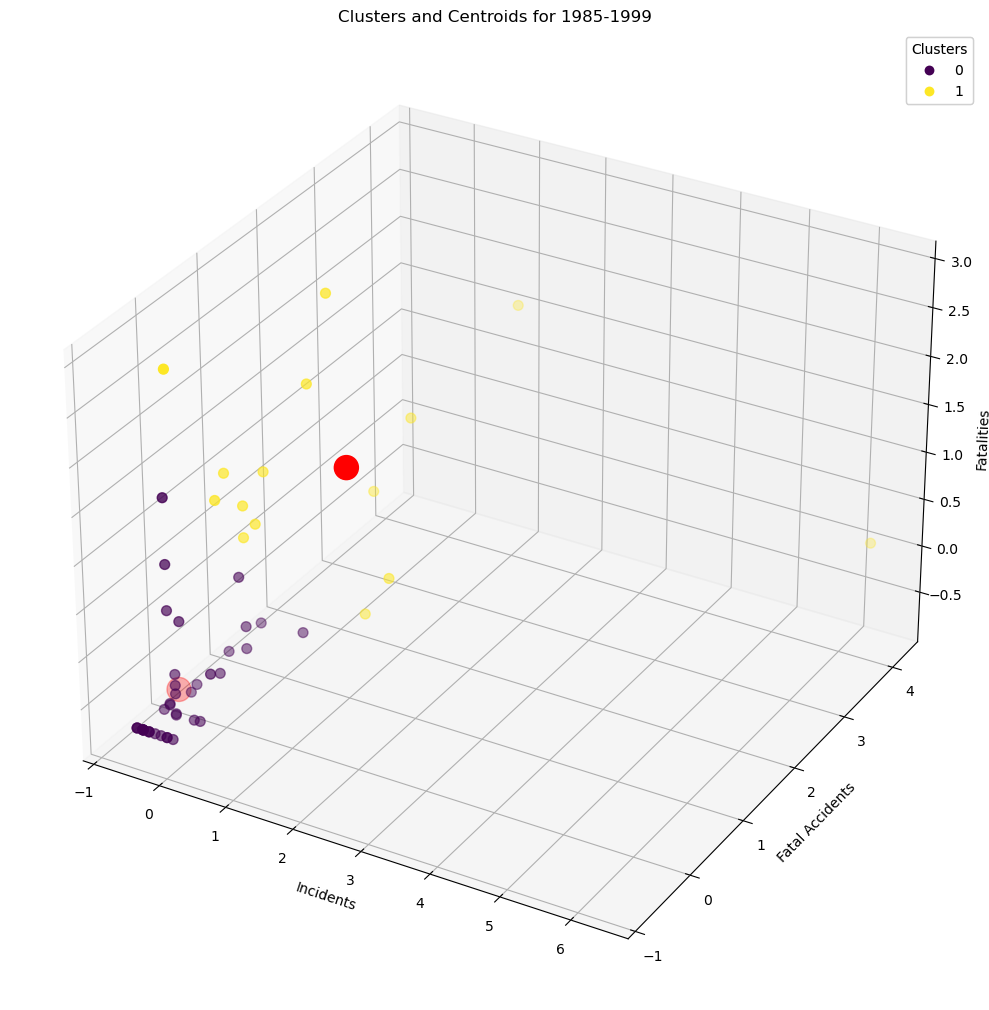

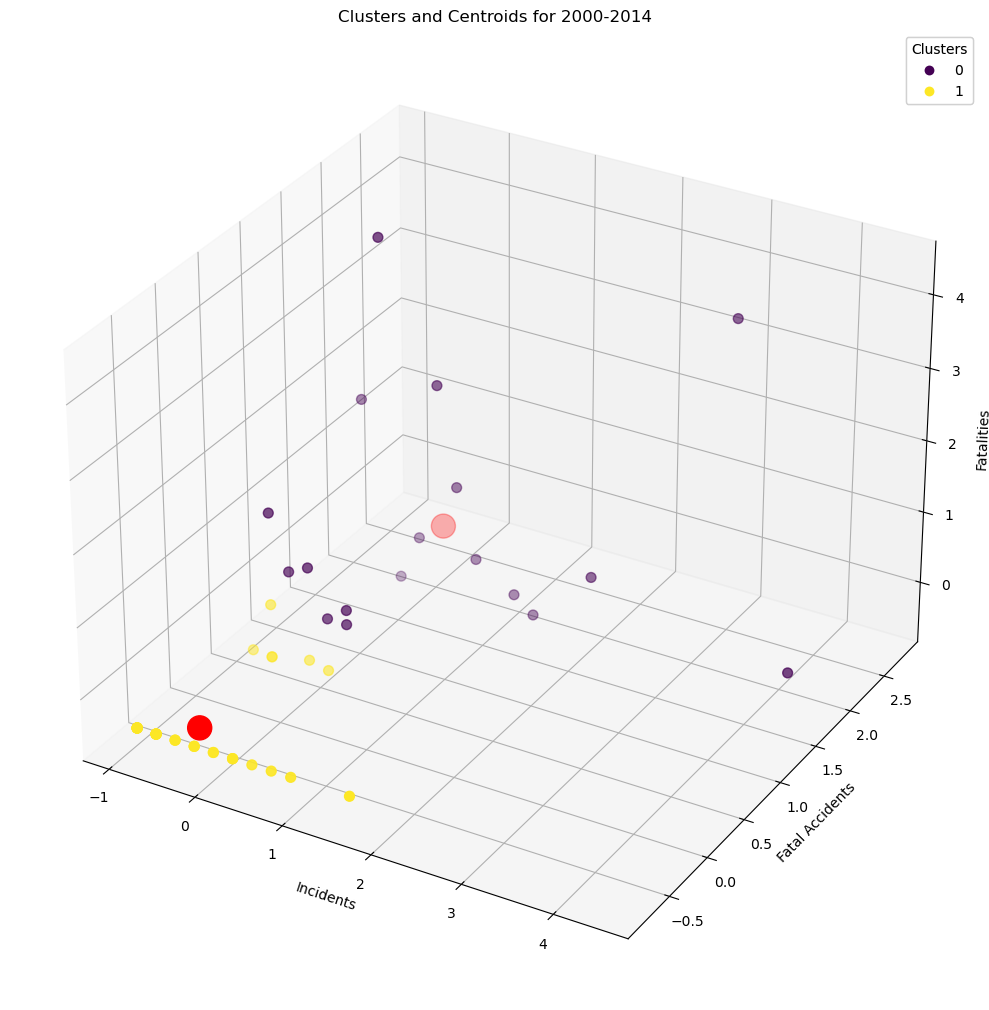

In [15]:
# Select variables from 1985-1999 from the scaled data order of columns is 0,1,2,3,4,5,6 corresponding to avail_seat_km_per_week, incidents_85_99, fatal_accidents_85_99, fatalities_85_99, incidents_00_14, fatal_accidents_00_14, fatalities_00_14,
features_85_99 = [1, 2, 3]
data_85_99_scaled = airline_scaled[:, features_85_99]

# Fit KMeans and predict labels
kmeans_85_99 = KMeans(n_clusters=2, random_state=5508)
labels_85_99 = kmeans_85_99.fit_predict(data_85_99_scaled)

# Select variables from 2000-2014 from the scaled data
features_00_14 = [4, 5, 6]
data_00_14_scaled = airline_scaled[:, features_00_14]

# Fit KMeans and predict labels
kmeans_00_14 = KMeans(n_clusters=2, random_state=5508)
labels_00_14 = kmeans_00_14.fit_predict(data_00_14_scaled)

# The design of this code largely comes from https://stackoverflow.com/questions/64987810/3d-plotting-of-a-dataset-that-uses-k-means
fig = plt.figure(figsize=(10, 15))

# Create 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the data points for 1985-1999
scatter = ax.scatter(data_85_99_scaled[:, 0], data_85_99_scaled[:, 1], data_85_99_scaled[:, 2], c=labels_85_99, s=50, cmap='viridis')

# Plot the centroids for 1985-1999
ax.scatter(kmeans_85_99.cluster_centers_[:, 0], kmeans_85_99.cluster_centers_[:, 1], kmeans_85_99.cluster_centers_[:, 2], s=300, c='red')

ax.set_title('Clusters and Centroids for 1985-1999')
ax.set_xlabel('Incidents')
ax.set_ylabel('Fatal Accidents')
ax.set_zlabel('Fatalities')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.subplots_adjust(left=0.15)
plt.tight_layout()
plt.show()

# Repeat the process for 2000-2014 data
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_00_14_scaled[:, 0], data_00_14_scaled[:, 1], data_00_14_scaled[:, 2], c=labels_00_14, s=50, cmap='viridis')

ax.scatter(kmeans_00_14.cluster_centers_[:, 0], kmeans_00_14.cluster_centers_[:, 1], kmeans_00_14.cluster_centers_[:, 2], s=300, c='red')

ax.set_title('Clusters and Centroids for 2000-2014')
ax.set_xlabel('Incidents')
ax.set_ylabel('Fatal Accidents')
ax.set_zlabel('Fatalities')

legend1 = ax.legend(*scatter.legend_elements(),
                    title="Clusters")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

### 2.6 K-means Cluster Analysis of Ratio Variables
---
Here another K-means clustering is performed but on the ratio of the incidents, fatal_accidents and fatalities features with the ratio being these features in 00_14 divided by the features in 85_99. The clustering is then performed on these features and the centroids plotted. From inspecting the graph it can be seen that theres key differences between the results of the ratio clusters and the results from task 4 in section <i>2.5</i> and task 2 in section <i>2.3</i>. In this cluster there is a stark distinction between cluster 0 and 1 with only 2 airlines in cluster 0 and the rest with very low average ratios in cluster 1. This could likely be due to the large number of 0 values from the ratio calculation in the dataset as fatal accidents are rare in aviation resulting in a large clustering of values towards the bottom left cluster. This is different to the results from task 4 in section <i>2.5</i> where the clusters showed significant changes over the time periods but were more evenly distributed. This could be because of a lower number of 0 values as there was no division calculation in this section. This analysis was also quite different from task 2 in section <i>2.3</i> where there were more evenly distributed clusters with the more dangerous airlines being clustered together.

Despite the differences, a common theme across the analyses is the clustering of low-risk airlines together, distinctly separated from high-risk airlines. This consistency suggests the robustness of clustering analysis in identifying safety patterns among airlines. However despite these commonalities the severe imbalance in the ratio based clustering points to a potential issue with using the ratios of the 85-99 to 00-14 data without accounting for the many zero values. All in all these various clustering analyses conducted offer valuable insights into how safety records of airlines have both changed over time and how they can be group together to provide a comparison. 

The number of zero values in each column:
airline                    0
avail_seat_km_per_week     0
incidents_85_99            3
fatal_accidents_85_99     17
fatalities_85_99          17
incidents_00_14            9
fatal_accidents_00_14     32
fatalities_00_14          32
Cluster                   12
incident_ratio            11
fatal_accident_ratio      37
fatality_ratio            37
dtype: int64


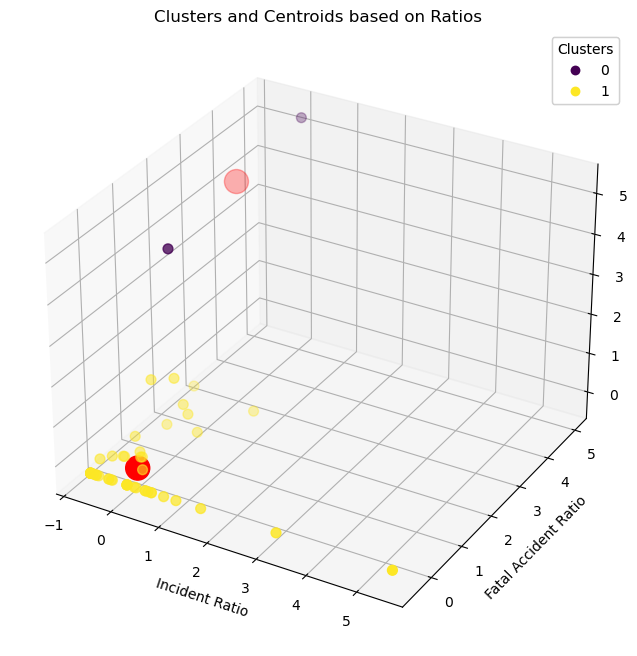

In [16]:
# Calculate the new features
airline_data['incident_ratio'] = airline_data['incidents_00_14'] / airline_data['incidents_85_99']
airline_data['fatal_accident_ratio'] = airline_data['fatal_accidents_00_14'] / airline_data['fatal_accidents_85_99']
airline_data['fatality_ratio'] = airline_data['fatalities_00_14'] / airline_data['fatalities_85_99']

# Handle infinite values due to division by zero
airline_data = airline_data.replace([np.inf, -np.inf], np.nan)

# Fill NA values with 0
airline_data = airline_data.fillna(0)

number_of_zeros_per_column = airline_data.apply(lambda x: (x == 0).sum())

print("The number of zero values in each column:")
print(number_of_zeros_per_column)

# Perform scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(airline_data[['incident_ratio', 'fatal_accident_ratio', 'fatality_ratio']])

kmeans = KMeans(n_clusters=2, random_state=5508)
labels = kmeans.fit_predict(scaled_features)

# Create a new DataFrame to store the airlines and their respective clusters
clustered_data = pd.DataFrame({'Airline': airline_data['airline'], 'Cluster': labels})

fig = plt.figure(figsize=(10, 8))

# Create 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], scaled_features[:, 2], 
                     c=labels, s=50, cmap='viridis')

# Plot the centroids
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], 
           s=300, c='red')

ax.set_title('Clusters and Centroids based on Ratios')
ax.set_xlabel('Incident Ratio')
ax.set_ylabel('Fatal Accident Ratio')
ax.set_zlabel('Fatality Ratio')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


## 3 Clustering Analysis on USArrests data
---
In this analysis we are looking into USArrests which are the crime rates related to various classes of crime such as assult, murder and rape per 100,000 residents across all 50 US states in the year 1973. The objective of the analysis is to employ hierarchical and K-means clustering techniques to group the states based on their crime rates and urban population in the hope that there is a trend or pattern among these features. If there is a trend to be found it can potentially help group US states together based on their danger or crime levels helping people stay informed of the dangers of states.

The USArrests data is 50 observations o nthe following 4 variables:
- Murder: murder arrests (per 100,000)
- Assault: assault arrests (per 100,000)
- Rape: rape arrests (per 100,000)
- UrbanPop: percent of the population living in urban areas

The dataset is completely numer


In [17]:
# imports
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np


### 3.1 Hierarchical Clustering
---
Here the data is loaded in and then using the raw data a hierarchical clustering with complete linkage and euclidean distance is used to group the states into clusters. Then a dendrogram is plotted and a height of 110 is chosen to cut the dendrogram into 3 distinct clusters. With these distinct clusters the states that belong to each cluster are printed and then three scatterplots are grahped to visualise how these states relate to the features of murder, assault and rape.

Inspecting the states responsible to each cluster it can be seen that the states in each cluster are as follows:
- Cluster 1
    - ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']
- Cluster 2
    - ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']
- Cluster 3
    - ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']

From the scatter plots below it can be clearly seen that there's some distinction between each cluster but alot of overlap. In all three categories each cluster is close to separated with cluster 1 in red having the highest crime rate on average for murder, assault and rape followed by cluster 2 and finally cluster 3. Inspecting the states that belong to each cluster we can start to draw inferences from this finding, in cluster 1 there are many densely populated states such as New York, California and Florida which can be seen in the scatter plot with more dots to the right of the x or urban population axis, it's likely that increased rates of crime comes hand in hand with an increased population. However despite this the only crime that seems to show a strong linear trend of increased crime rate with increased urban population is rape. In the other scatter plots there seems to be a clear distinction between clusters regardless of urban population suggesting that the clustering has grouped together higher risk or higher crime states and then middle crime and lower crime states which is especially apparent in the assault scatter plot.

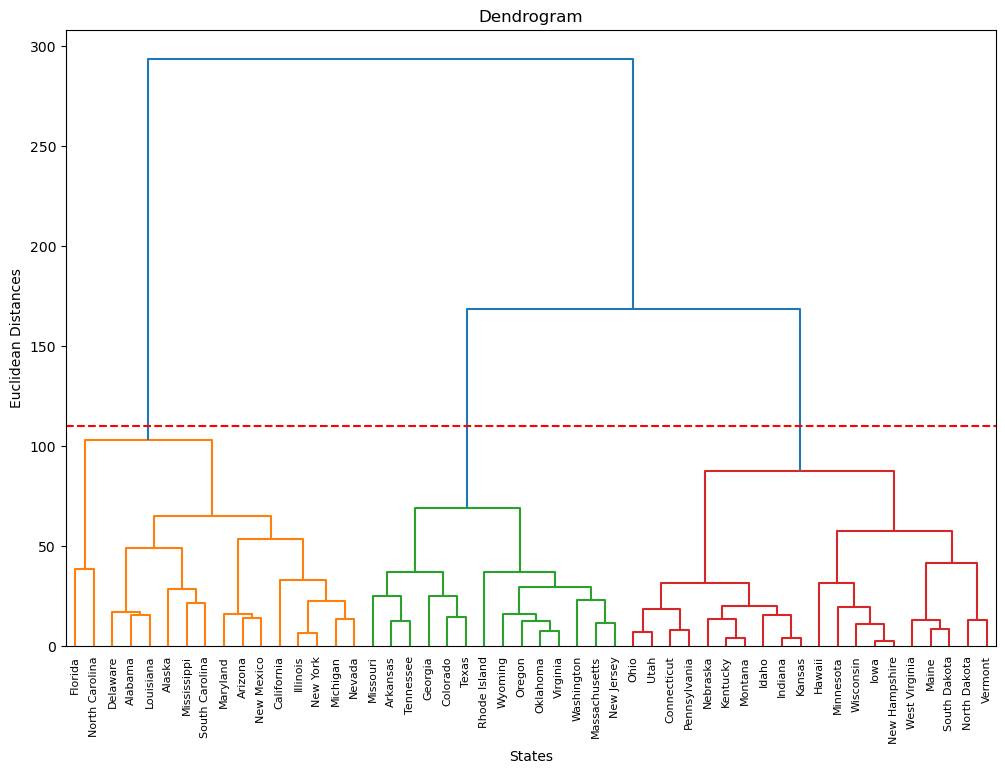

Cluster 1:
['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']
Cluster 2:
['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']
Cluster 3:
['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']


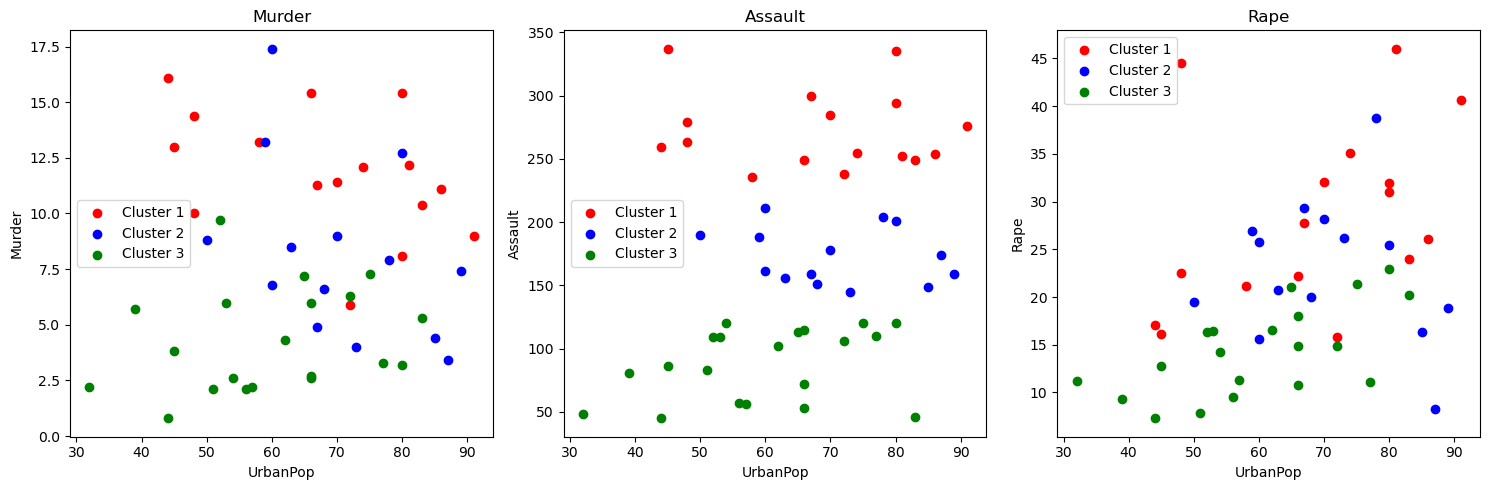

In [18]:
# Load the data
data = pd.read_csv('USArrests.csv', index_col=0)

# Generate the linkage matrix using complete linkage and Euclidean distance
linkmatrix = linkage(data, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkmatrix, labels=data.index, color_threshold=110)
plt.axhline(y=110, color='r', linestyle='--') 
plt.title('Dendrogram')
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

# Cut the dendrogram at a height that results in three distinct clusters
cut = 110
clusters = fcluster(linkmatrix, cut, criterion='distance')

# Map each state to its cluster
data['Cluster'] = clusters

# Display the states in each cluster
for i in range(1, 4):
    print(f"Cluster {i}:")
    print(data[data['Cluster'] == i].index.tolist())
    
# Plot scatter plots of features with each cluster
crime_types = ['Murder', 'Assault', 'Rape']
colors = ['red', 'blue', 'green']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    for j in range(1, 4):
        subset = data[data['Cluster'] == j]
        ax.scatter(subset['UrbanPop'], subset[crime_types[i]], color=colors[j-1], label=f'Cluster {j}')
    ax.set_title(crime_types[i])
    ax.set_xlabel('UrbanPop')
    ax.set_ylabel(crime_types[i])
    ax.legend()

plt.tight_layout()
plt.show()

### 3.2 Hierarchical Clustering Post Scaling
---
Here the same steps are taken as in section <i>3.1 </i> however the data is scaled to have zero mean and standard deviation before the steps are undertaken. The resulting clusters are as follows:

- Cluster 1:
    - ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
- Cluster 2:
    - ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
- Cluster 3:
    - ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']

As can be seen from both the states that are grouped in each cluster and the dendrogram scaling the data has a significant affect on the hierarchical clustering result. The process of scaling each feature to have zero mean and standard deviation ensures that no feature contributes more than others to the formation of clusters which is important for scale sensitive methods like hierarchical clustering. This changes the membership of the clusters and creates a much stronger separation between each cluster in the scatter plots printed below where it can be clearly seen that cluster 1 has the lowest crime rates on average. It looks like this clustering has put low crime states in cluster 1, high crime and low urban populations in cluster 3 as can be seen in the scatter plots with the majority of points to the left of the x axis and then high crime and high urban populations in cluster 2. This is a better clustering than the pre scaled data as it provides a much clearer distinction between clusters of states. As a result of these better results, the scale sensitive nature of clustering methods and the fact that the features in the dataset can take wildly different scales I believe that the data should be scaled before clustering.

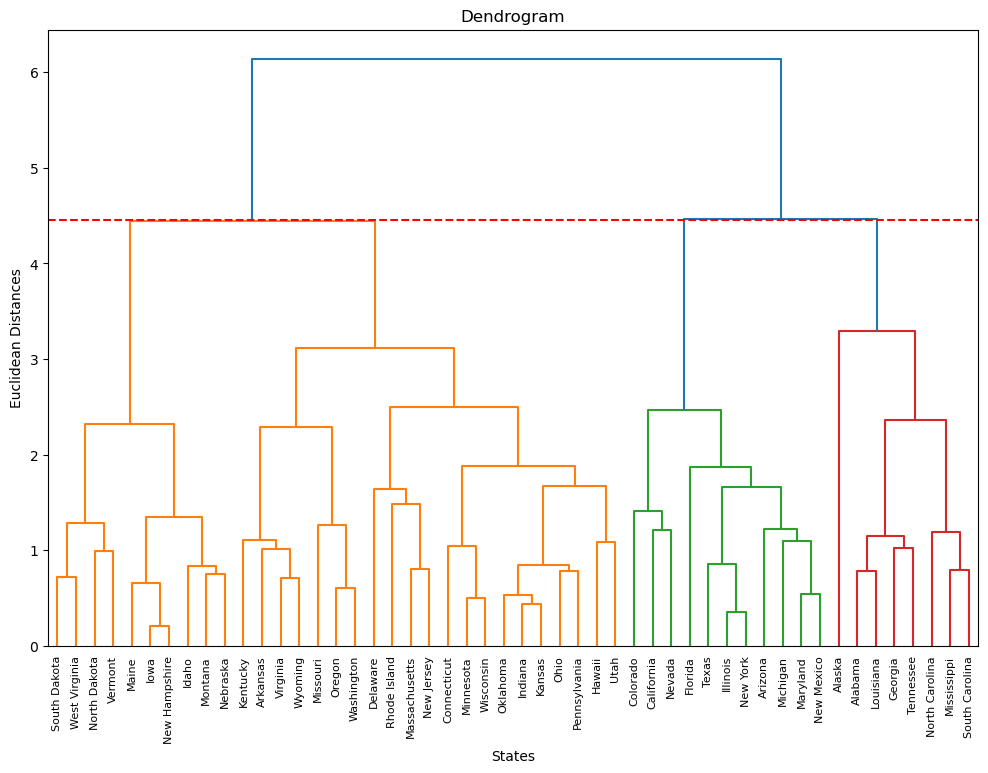

Cluster 1:
['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 2:
['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 3:
['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


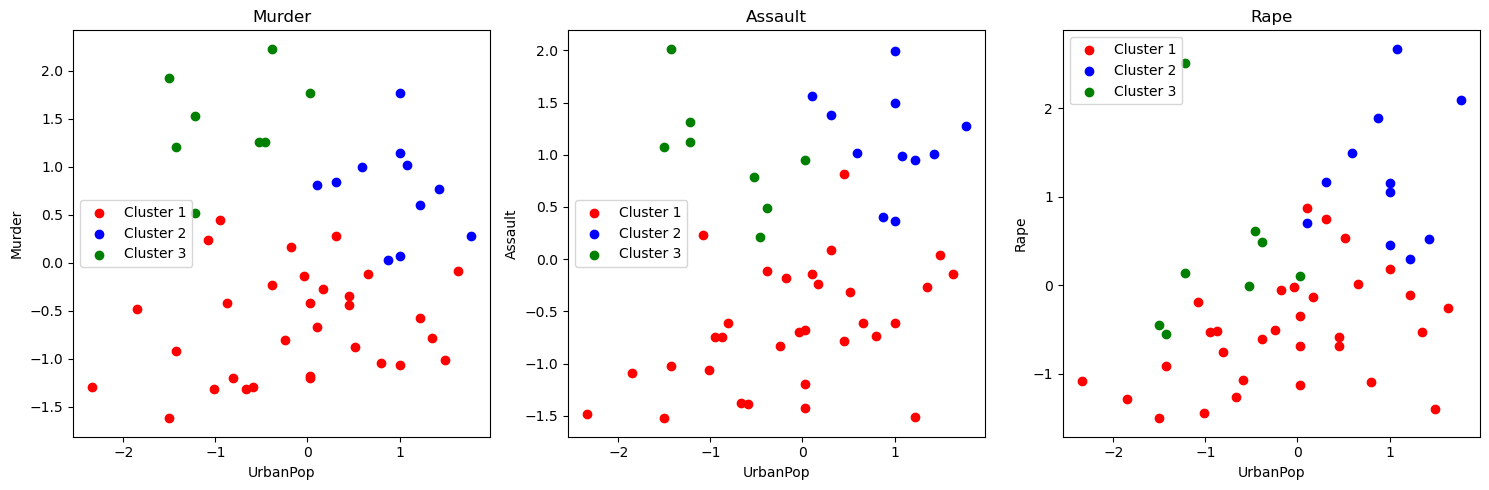

In [19]:
# Freshly load data
data = pd.read_csv('USArrests.csv', index_col=0)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

# Generate the linkage matrix using complete linkage and Euclidean distance
linkmatrix = linkage(data_scaled, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkmatrix, labels=data_scaled.index, color_threshold=4.45)
plt.axhline(y=4.45, color='r', linestyle='--') 
plt.title('Dendrogram')
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

# Cut the dendrogram at a height that results in three distinct clusters
cut = 4.45 
clusters_scaled = fcluster(linkmatrix, cut, criterion='distance')


# Map each state to its cluster
data_scaled['Cluster'] = clusters_scaled

# Display the states in each cluster
for i in range(1, 4):
    print(f"Cluster {i}:")
    print(data_scaled[data_scaled['Cluster'] == i].index.tolist())
    
crime_types = ['Murder', 'Assault', 'Rape']
colors = ['red', 'blue', 'green']

# Plot scatter plots of features with each cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    for j in range(1, 4):
        subset = data_scaled[data_scaled['Cluster'] == j]
        ax.scatter(subset['UrbanPop'], subset[crime_types[i]], color=colors[j-1], label=f'Cluster {j}')
    ax.set_title(crime_types[i])
    ax.set_xlabel('UrbanPop')
    ax.set_ylabel(crime_types[i])
    ax.legend()

plt.tight_layout()
plt.show()


### 3.3 PCA and Hierarchical Clustering
---
Here PCA is performed on the data and then the same steps as the sections above were performed to complete hierarchical clustering with complete linkage and euclidean distance on these first two principal components. The resulting clusters have these states:
- Cluster 1:
    - ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
- Cluster 2:
    - ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
- Cluster 3:
    - ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']

Looking at the scatterplot the separation between clusters from the PCA Hierarchical clustering is even clearer than in the scaled clusters from section <i>3.2</i> above with a clear grouping of states in cluster 1 at the left of the first principal component, and then cluster 2 in the top right (high value of both principal components) and cluster 3 in the bottom right (a high first principal component but a low second principal component value). This step also changed the membership of the clusters with cluster 2s states from task 2 becoming cluster 3 in task 3 and vice versa. There is a similar grouping of characteristics of states that was observed in task 2 where clusters had states of high crime high population, high crime low population and low crime varying populations, however the PCA scatterplot makes this grouping much clearer with a cluster 1 distinct from the others with a low first principal component and varying second principal component, then cluster 2 and 3 with high principal component 1 and either high or low principal component 2. This grouping of characteristics of states can be seen if the membership of each cluster is inspected with the high crime high population states in cluster 3 such as New York, California ect, the varying crime and small rurual populations like arkansas and idaho in cluster 1 and the high crime low population states in cluster 2 like Georgia and South Carolina.

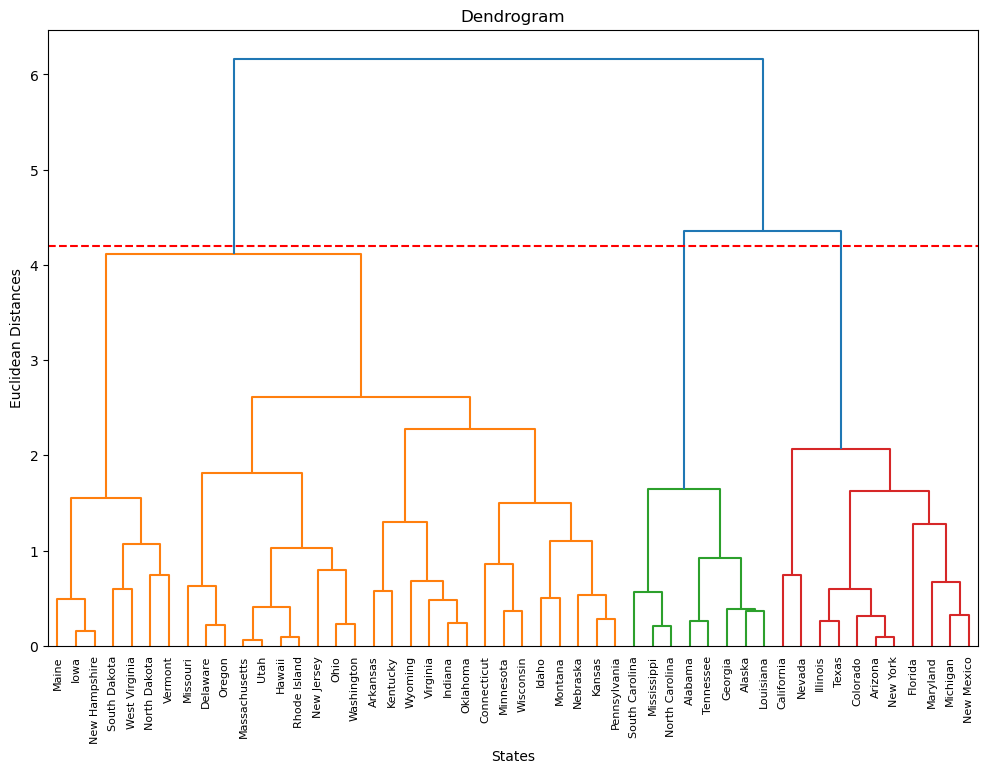

Cluster 1:
['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 2:
['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
Cluster 3:
['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']


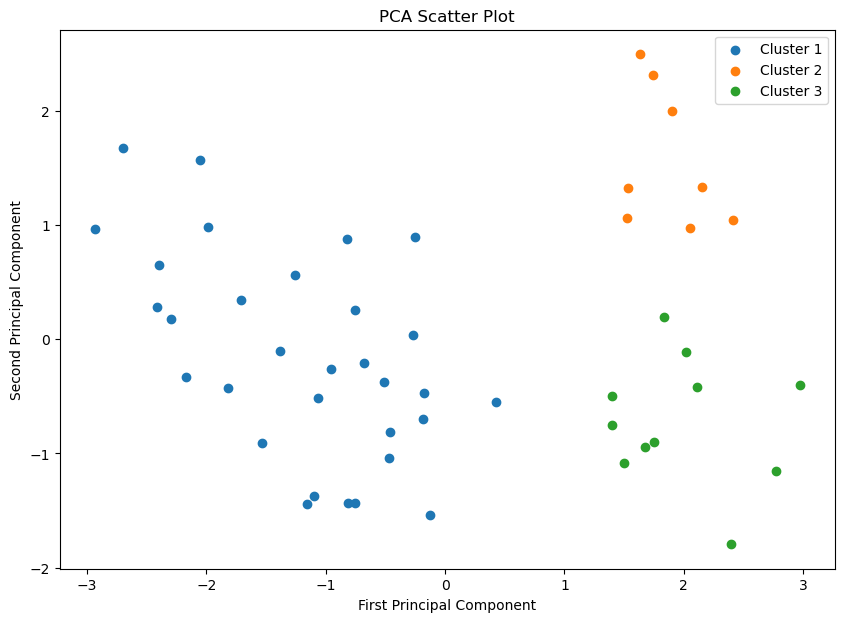

In [20]:
# Perform PCA analysis
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'], index=data_scaled.index)

# Generate the linkage matrix using complete linkage and Euclidean distance
linkmatrix_pca = linkage(data_pca, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkmatrix_pca, labels=data_pca.index, color_threshold=4.2)
plt.axhline(y=4.2, color='r', linestyle='--')  
plt.title('Dendrogram')
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

# Cut the dendrogram at a height that results in three distinct clusters
cut = 4.2
clusters_pca = fcluster(linkmatrix_pca, cut, criterion='distance')

# Map each state to its cluster
data_pca['Cluster'] = clusters_pca

# Display the states in each cluster
for i in range(1, 4):
    print(f"Cluster {i}:")
    print(data_pca[data_pca['Cluster'] == i].index.tolist())

# Scatter plot of the first 2 principal components
plt.figure(figsize=(10, 7))
for i in range(1, 4):
    subset = data_pca[data_pca['Cluster'] == i]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {i}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.title('PCA Scatter Plot')
plt.show()




### 3.4 K-Means Clustering of PCA
---
Here instead of hierarchical clustering K-means clustering with a K value of 3 is performed on the first two principal components as features with the initial centroids coming from the group means from task 3 in section <i> 3.3 </i> above. The resulting clusters are as follows:
- Cluster 1
    - ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
- Cluster 2:
    - ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
- Cluster 3:
    - ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']

From inspection of these clusters and the resulting scatter plot that is displayed below it can be seen that the results of the K-means clustering are very similar to the results of the hierarchical clustering. There's only a single change to the clusters with one state moving from cluster 1 to cluster 3 in the K-means clustering which signifies that the decision boundary for the separation between these clusters has shifted to the left on the first principal axis. This shift can be seen in the scatter plot where the state at ~ 0.2 on the first principal axis has moved from cluster 1 to cluster 3. In the context of the data it seems that the results from this task are similar to the results above where states grouped in cluster 2 and 3 have high values of principal component 1 meaning they are the most dangerous states, these findings make sense as these states are much more densely populated than the states in the first cluster with states like california, New York and Texas included in these clusters. 

Despite this the K-means clustering still provides a very good distinction between clusters and as a result it would be difficult to decide which method is better. If a clear distinct separation between groupings of states is desired than the hierarchical clustering had a (very) slightly better separation between clusters of states however if speed or computational cost is a concern then K-means clustering is generally faster and more scalable to bigger datasets and as a result would be the better option. Overall both K-means and hierarchical clustering provided valuable insights into the groups of states with similar safety metrics.

K-means Cluster 1:
['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
K-means Cluster 2:
['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
K-means Cluster 3:
['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']


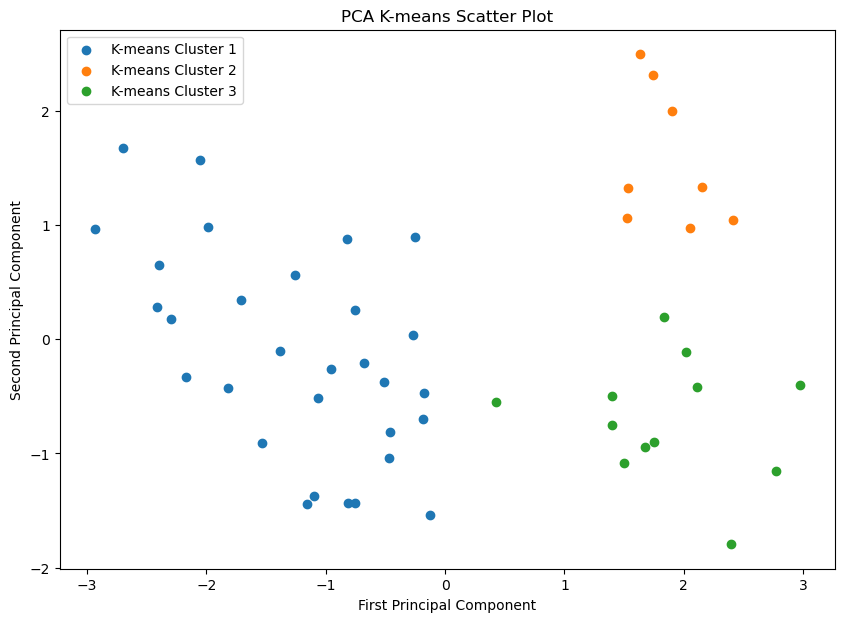

In [21]:
# Calculate initial centroids from hierarchical clustering results of Task 3
centroids_initial = []
for i in range(1, 4):
    subset = data_pca[data_pca['Cluster'] == i]
    centroid = subset[['PC1', 'PC2']].mean().values.tolist()
    centroids_initial.append(centroid)
centroids_initial = np.array(centroids_initial)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, init=centroids_initial, random_state=5508)
kmeans.fit(data_pca[['PC1', 'PC2']])  # Only consider PC1 and PC2 for clustering

# Map each state to its K-means cluster
data_pca['KMeans_Cluster'] = kmeans.labels_

# Display the states in each K-means cluster
for i in range(3):
    print(f"K-means Cluster {i+1}:")
    print(data_pca[data_pca['KMeans_Cluster'] == i].index.tolist())

# Plot the K-means clusters
plt.figure(figsize=(10, 7))
for i in range(3):
    subset = data_pca[data_pca['KMeans_Cluster'] == i]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'K-means Cluster {i+1}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.title('PCA K-means Scatter Plot')
plt.show()
